# Aprendizaje Automático - Práctica 3 - Aprendizaje Profundo

#### Valoración máxima: 10 puntos

#### Fecha límite de entrega: 9 de Junio de 2024 a las 23:59

#### Entrega a través de https://pradogrado2324.ugr.es/

### Nombre completo: <mark>ELENA TORRES FERNÁNDEZ</mark>



---


**Normas de desarrollo y entrega de trabajos**

- Única y exclusivamente se debe entregar este Notebook de Colab (fichero `.ipynb`) o, en su defecto, dos Notebooks de Colab (uno con cada ejercicio). No de debe entregar ninguna memoria externa (por ejemplo, en `.pdf`).

- __El código debe estar bien comentado (explicando lo que realizan los distintos apartados y/o bloques), y todas las decisiones tomadas y el trabajo desarrollado (incluyendo los conceptos fundamentales subyacentes) deben documentarse ampliamente en celdas de texto. Es obligatorio documentar las valoraciones y decisiones adoptadas en el desarrollo de cada uno de los apartados. Debe incluirse también tanto una descripción de las principales funciones (Python/scikit-learn) empleadas (para mostrar que el alumno comprende, a nivel técnico, lo que está haciendo), como una valoración razonada sobre la calidad de los resultados obtenidos. Sin esta documentación, se considera que el trabajo NO ha sido presentado.__

- La entrega en PRADO está configurada para permitir sucesivas entregas de la práctica. Desde este punto de vista, se recomienda subir versiones de la práctica a medida que se van realizando los distintos ejercicios propuestos, y no dejarlo todo para el final.  

- Se debe respetar la estructura y secciones del Notebook. Esto servirá para agilizar las correcciones, así como para identificar con facilidad qué ejercicio/apartado se está respondiendo.

- El código NO puede escribir nada a disco.

- El path de lectura desde Google Drive debe ser siempre el mismo, que es el que se indica en este Notebook.

- Una entrega es apta para ser corregida si se puede ejecutar de principio a fin sin errores. Es decir, un ejercicio con errores de ejecución tendrá una calificación de 0.

- No es válido usar opciones en las entradas (es decir, utilizar el comando `input()`, por ejemplo, para que el usuario escoja el valor de las variables para ejecutar el programa). Para ello, se deben fijar al comienzo los valores
por defecto que se consideren óptimos o que se soliciten en el enunciado.

- Se entrega solamente este Notebook, y no los datos empleados.


---

<font color='blue'> En esta práctica se pretenden abordar algunos elementos básicos relativos al aprendizaje profundo utilizando Keras (https://keras.io/). Para ello, se emplean dos tareas del ámbito del procesado de imágenes y visión por computador: clasificación de imágenes (_image classification_) y eliminación de ruido en imágenes (_image denoising_). Para tener un conocimiento más profundo de algunas de estas tareas y métodos, así como familiarizarse con modelos más avanzados, se emplaza al estudiantado a cursar Visión por Computador (asignatura de 4º curso).

# <font color='blue'>Ejercicio 1: PROBLEMA DE CLASIFICACIÓN DE IMÁGENES USANDO REDES CONVOLUCIONALES PROFUNDAS Y COMPARACIÓN CON TÉCNICAS CLÁSICAS DE APRENDIZAJE AUTOMÁTICO (7 puntos) </font>

<font color='blue'> En este ejercicio los alumnos se enfrentarán a un problema de clasificación de imágenes. Más concretamente, se enfrentarán al problema de clasificación de imágenes denominado $\textit{MNIST}$ (https://en.wikipedia.org/wiki/MNIST_database), que incluye dígitos manuscritos. Como consecuencia, este conjunto de datos contiene información sobre 10 clases de imágenes (dígitos del $0$ al $9$).

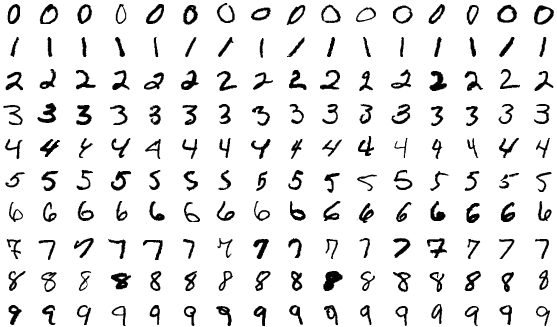



<font color='blue'> Este ejercicio consta de tres apartados:


1.   Implementación y experimentación con una red convolucional sencilla inspirada en LeNet5.
2.   Implementación y experimentación con características HOG y SVMs. Comparación de los resultados proporcionados por esta aproximación clásica con los proporcionados por aprendizaje profundo.
3.   Implementación y experimentación con el modelo profundo que quieran implementar o emplear los estudiantes.



## <font color='blue'> Apartado 1. Implementación y experimentación con una red convolucional sencilla inspirada en LeNet5 (3 puntos)

<font color='blue'> [LeNet5](https://en.wikipedia.org/wiki/LeNet) fue una de las primeras redes convolucionales, y se empleó exitosamente ya en los años 90 en la clasificación de dígitos manuscritos. Véase, por ejemplo, _LeCun et al. (1998). Gradient based learning applied to document recognition. Proceedings of the IEEE. 86(11): 2278-2324_.

<font color='blue'> En este ejercicio emplearemos una versión ligeramente modificada de la misma, que consta de las siguientes capas:

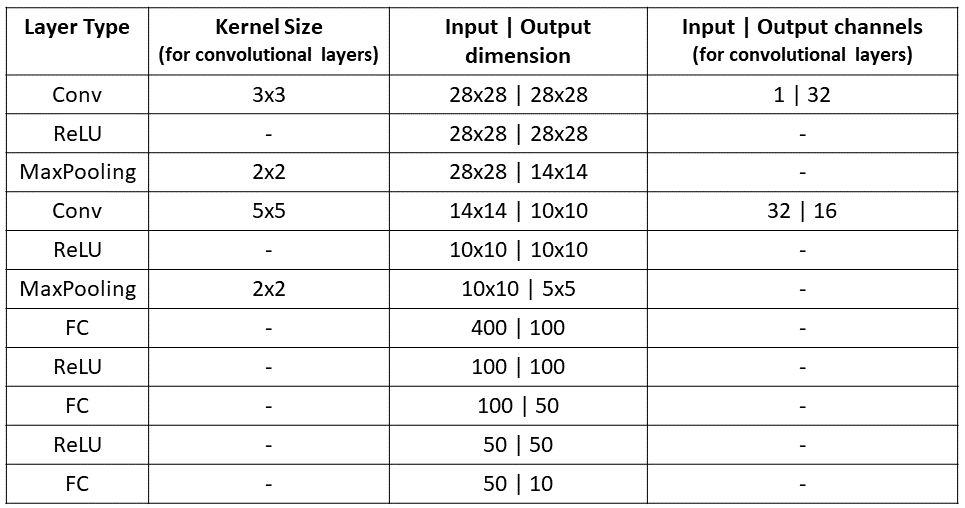

<font color='blue'> A continuación, el alumnado debe implementar en Keras esta arquitectura, y entrenarla y validarla con el conjunto de datos MNIST (ya disponible entre los conjuntos de datos por defecto en Keras: https://keras.io/api/datasets/). A la hora de entrenar modelos profundos es importante acordarse de configurar el cuaderno de modo que se ejecute en GPU (`Editar - Configuración del Cuaderno - Acelerador por Hardware`). De lo contrario, los entrenamientos serán innecesariamente lentos.

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from tabulate import tabulate

# Establecer la semilla que vamos a utilizar
np.random.seed(42)

from tensorflow import keras

#import keras
!pip install np_utils
from keras.utils import to_categorical
from keras.datasets import mnist, cifar10
keras.utils.set_random_seed(42)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization
from keras import backend as K
from keras.optimizers import AdamW, Adadelta
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping
from keras.metrics import F1Score

# NÚMERO DE CLASES
num_classes = 10

# DIMENSIONES DE ENTRADA DE LAS IMAGENES
img_rows, img_cols = 28, 28

# CARGAMOS LOS DATOS DE ENTRENAMIENTO Y TEST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# según el orden en el formato de la imagen
# número de canales: 1 pq son imágenes en blanco y negro
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# FORMATEAMOS Y NORMALIZAMOS LOS DATOS
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Transformamos los vectores de clases en matrices.
# Cada componente se convierte en un vector de ceros
# con un uno en la componente correspondiente a la
# clase a la que pertenece la imagen. Este paso es
# necesario para la clasificación multiclase en keras.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 601.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56441 sha256=1f2830ac48f30438b1f8be3f8fa4c80505df138617e66c430ff85e257bd0c85e
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils
11490434/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


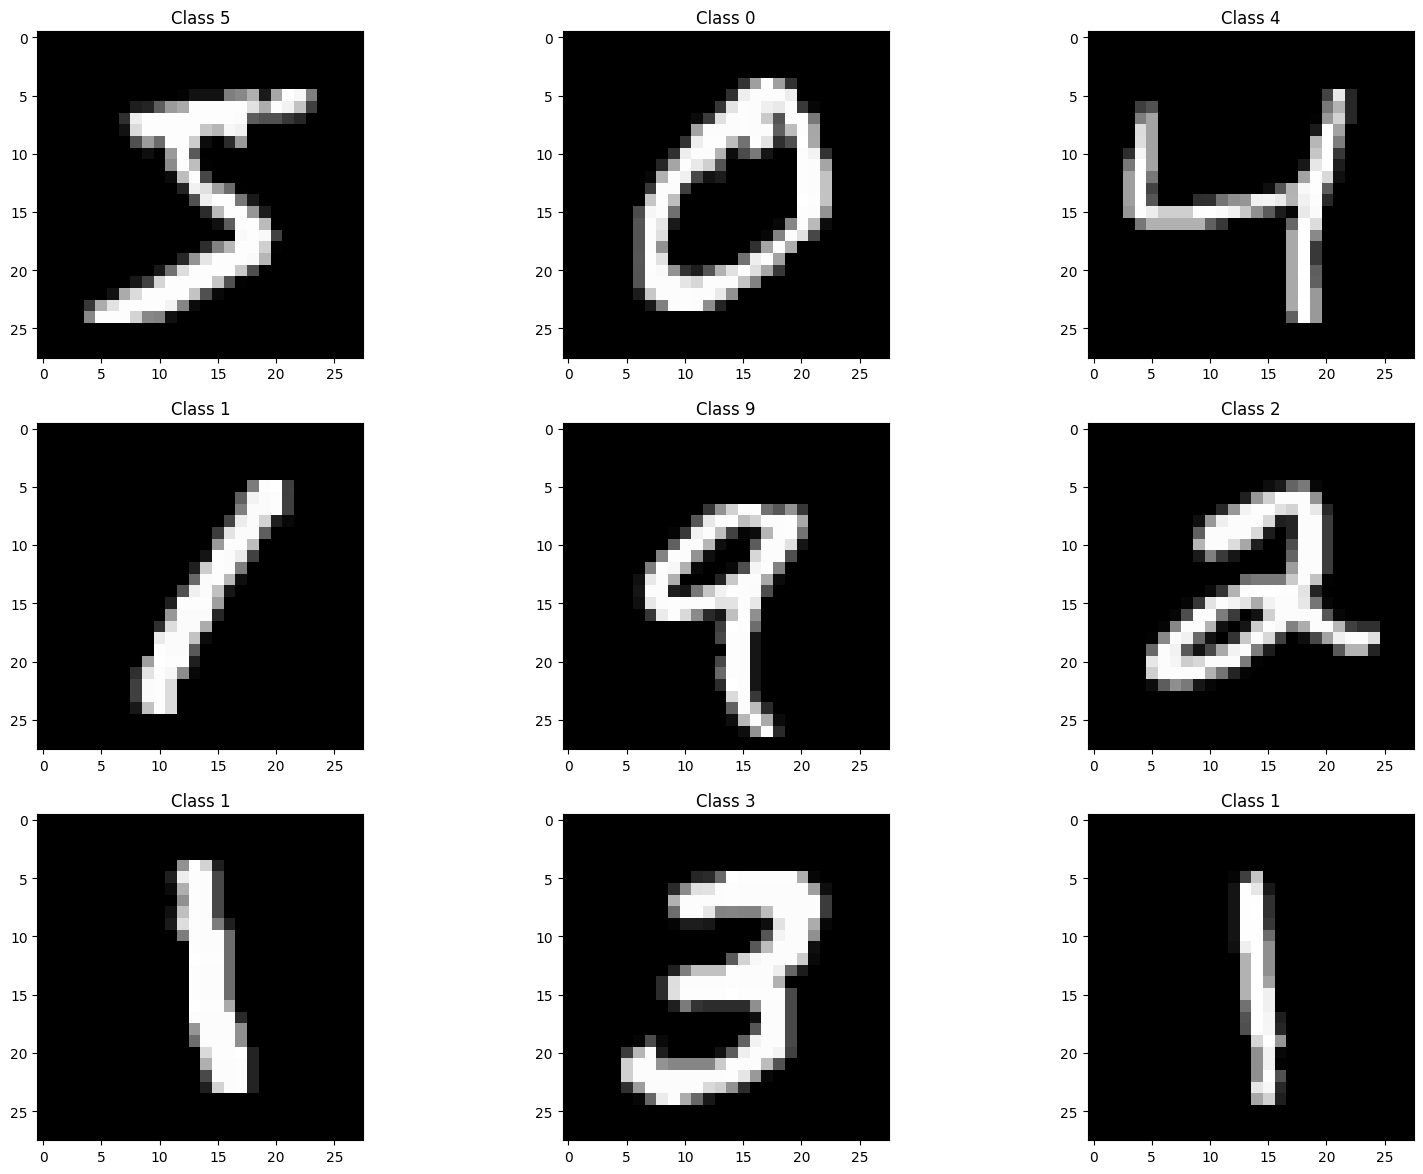

In [ ]:
#VISUALIZAMOS ALGUNAS DE LAS IMÁGENES DEL DATASET
number_images_per_row = 3
result = np.where(y_train == 1)
fig = plt.figure()
for i in range(number_images_per_row*number_images_per_row):
  label = 'Class {}'.format(result[1][i])
  plt.subplot(number_images_per_row,number_images_per_row,i+1).set_title(label)
  plt.imshow(x_train[i].squeeze(), cmap='gray',vmin=0,vmax=1)

fig.set_size_inches(np.array(fig.get_size_inches()) * number_images_per_row)

plt.show()

<font color='blue'> El alumnado debe escoger empíricamente el tamaño de _batch_, el número de épocas y el _learning rate_. Se debe documentar en detalle todo el proceso de entrenamiento y selección de hiperparámetros (incluyendo qué metricas y función de pérdida se emplean y por qué). Se debe emplear _early stopping_ (https://keras.io/api/callbacks/early_stopping/), y los alumnos deben explicar en qué consiste este proceso de regularización. Se puede emplear tanto _hold-out_ como _cross-validation_ como protocolo de validación experimental pero, en cualquier caso, se deben explicar y justificar adecuadamente todas las decisiones tomadas. Se debe dejar un $20\%$ de los datos de entrenamiento para validación. Finalmente, se debe comparar el rendimiento obtenido con dos optimizadores: AdamW y Adadelta.

<font color='blue'> Resulta fundamental realizar un _.summary()_ del modelo creado y demostrar que se comprenden los distintos elementos que allí aparecen: nombre/tipo de capa, dimensiones de salida, y número de parámetros de la red.

In [ ]:
# Esta función pinta dos gráficas, una con la evolución
# de la función de pérdida en el conjunto de train y
# en el de validación, y otra con la evolución de la
# accuracy en el conjunto de train y el de validación.
# Es necesario pasarle como parámetro el historial del
# entrenamiento del modelo (lo que devuelve la
# función fit()).
def mostrarEvolucion(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.show()

    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training accuracy','Validation accuracy'])
    plt.show()


In [ ]:
# Esta función devuelve la accuracy de un modelo,
# definida como el porcentaje de etiquetas bien predichas
# frente al total de etiquetas. Como parámetros es
# necesario pasarle el vector de etiquetas verdaderas
# y el vector de etiquetas predichas, en el formato de
# keras (matrices donde cada etiqueta ocupa una fila,
# con un 1 en la posición de la clase a la que pertenece y un 0 en las demás).
def calcularAccuracy(labels, preds):
    labels = np.argmax(labels, axis = 1)
    preds = np.argmax(preds, axis = 1)
    accuracy = sum(labels == preds)/len(labels)
    return accuracy


Ahora mismo tenemos los datos divididos en train y test. Vamos a crear un nuevo **subconjunto de datos para validación** cogiendo el 20% de los datos de entrenamiento. Para ello, usamos la función StratifiedShuffleSplit de scikit-learn para realizar una división estratificada. Así, tenemos nuestro conjunto de datos dividido en train, validation y test.

In [ ]:
print('x_train shape:', x_train.shape)   # ( número de imágnes, altura en pixeles, anchura en pixeles, número de canales (1: blanco y negro) )
print(x_train.shape[0], 'train samples') # número de imágenes del conjunto de entrenamiento
print(x_test.shape[0], 'test samples')   # número de imágenes del conjunto de test

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [18]:
# separamos los datos de entrenamiento en train y validation de forma estratificada
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
X_train = []
x_vali = []
Y_train = []
y_vali = []

for i, (train_index, vali_index) in enumerate(sss.split(x_train, y_train)):
  X_train = x_train[train_index]
  x_vali = x_train[vali_index]
  Y_train = y_train[train_index]
  y_vali = y_train[vali_index]

In [ ]:
print(X_train.shape[0], 'train samples') # número de imágenes del conjunto de entrenamiento
print(x_vali.shape[0], 'validation samples')   # número de imágenes del conjunto de test

48000 train samples
12000 validation samples


A continuación, según los pasos de creación de un clasificador en Keras, **definimos el modelo** creando las capas que se nos indican en la tabla de arriba. Usamos el modelo de red neuronal **Sequential**, el cual fuerza a que todas las capas de la red vayan una detrás de otra de forma secuencial, sin permitir ciclos ni saltos entre capas.

Una vez creado el modelo llamando a *Sequential()*, **añadimos las capas** mediante *add*:

*   La <u>primera capa</u> es una convolución con un filtro de 3x3, lo que indicamos con el parámetro kernel_size=(3,3). Al aplicarla se mantiene el tamaño original de las imágenes (28x28), lo que indicamos con stride=1 y padding="same". filters=32 indica el número de canales en la salida. Con el parámetro input_shape representamos el formato de entrada a esta capa, que rellenamos según la tabla. Tras esta capa se llama a una función de activación ReLU, lo que indicamos con el parámetro activation="relu".

*   La <u>segunda capa</u> es un maxpooling de filtro 2x2, lo que indicamos con el parámetro pool_size=(2,2). Con ello, la imagen pasa de ser de 28x28 a 14x14, sin necesidad de hacer padding ni añadir un stride, pues la división 28/2=14 es entera.

*   La <u>tercera capa</u> es una convolución con un filtro de 5x5 (kernel_size=(5,5)) que reduce la imagen de 14x14 a 10x10. filters=16 indica el número de canales en la salida. Con el parámetro input_shape representamos el formato de entrada a esta capa, que rellenamos según la tabla. Tras la convolución se introduce una función de activación relu, añadiendo el parámetro activation="relu".

*   La <u>cuarta capa</u> es igual que la segunda.

*   La <u>quinta capa</u> es una tipo *Flatten* para que se aplanen las características extraídas y se pase a la fase de clasificación con ellas.

*   La <u>sexta capa</u> es una capa densa o fully-connected, que da como salida 100 neuronas (units=100). Le sigue una función de activación relu.

*    La <u>séptima capa</u> es una capa densa o fully-connected, que da como salida 50 neuronas (units=50). Le sigue una función de activación relu.

*    La <u>octava capa</u> es una capa densa o fully-connected con una función de activación softmax (activation="softmax"), siendo la capa que actúa como clasificador. Al haber 10 clases, su salida es, efectivamente, de 10 neuronas (units=10).

In [ ]:
# Primer modelo al que se le aplicará optimización adamw
modelAW = Sequential()

# feature learning
modelAW.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, padding="same", activation="relu", input_shape = input_shape))
modelAW.add(MaxPooling2D(pool_size=(2,2)))
modelAW.add(Conv2D(filters=16, kernel_size=(5,5), activation="relu", input_shape = (14,14,32)))
modelAW.add(MaxPooling2D(pool_size=(2,2)))

# classification
modelAW.add(Flatten())
modelAW.add(Dense(units=100, activation="relu"))
modelAW.add(Dense(units=50, activation="relu"))
modelAW.add(Dense(units=10, activation="softmax")) # regresión logística multinomial


# Segundo modelo, con la misma estructura de capas que el primero, al que se le aplicará optimización adadelta
modelAD = Sequential()

# feature learning
modelAD.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, padding="same", activation="relu", input_shape = input_shape))
modelAD.add(MaxPooling2D(pool_size=(2,2)))
modelAD.add(Conv2D(filters=16, kernel_size=(5,5), activation="relu", input_shape = (14,14,32)))
modelAD.add(MaxPooling2D(pool_size=(2,2)))

# classification
modelAD.add(Flatten())
modelAD.add(Dense(units=100, activation="relu"))
modelAD.add(Dense(units=50, activation="relu"))
modelAD.add(Dense(units=num_classes, activation="softmax")) # regresión logística multinomial


Una vez definimos 2 modelos con las mismas capas, viene la fase de **declaración del optimizador**. Vamos a crear 2 modelos distintos, según el optimizador usado: modelAW, con un optimizador AdamW; y modelAD, con un optimizador Adadelta. Establecemos a priori el parámetro de learning_rate a 0.001, su valor por defecto. El optimizador lo añadimos directamente en la fase de compilación.

Pasamos a la fase de **compilación del modelo**. Usamos la función de pérdida *categorical_crossentropy*, utilizada en redes neuronales para
la clasificación multiclase, donde a cada muetra de los datos se le asigna una única etiqueta de clase. Esta función cuantifica la diferencia entre dos distribuciones de probabilidad discretas. Las métricas que se estudian para las comparaciones son *accuracy* y *f1-score*. Empezamos poniendo el learning_rate por defecto.

In [ ]:
metric_f1= F1Score(name="f1_score", average='weighted')

modelAW.compile(loss="categorical_crossentropy", metrics=['accuracy', metric_f1], optimizer=AdamW(learning_rate=1e-3))
modelAD.compile(loss="categorical_crossentropy", metrics=['accuracy', metric_f1], optimizer=Adadelta(learning_rate=1e-3))

In [ ]:
# nos guardamos los pesos antes del entrenamiento para posteriormente reiniciar
# los pesos con estos valores y poder optimizar los hiperparámetros de forma justa
weightsAW = modelAW.get_weights()
weightsAD = modelAD.get_weights()

Una vez compilados los 2 modelos, pasamos al **entrenamiento** con el conjunto de datos X_train antes definido. Parámetros del fit: batch_size y epochs por defecto ahora mismo. Aplicamos regularización con parámetros estándares.

In [ ]:
# Establecemos los parámetros de batch_size, epochs y patience de forma estándar
nbatch = 2
nepochs = 10
callback = EarlyStopping(monitor='accuracy', patience=3)    # regularización

historia1 = modelAW.fit( x=X_train, y=Y_train, batch_size=nbatch, epochs=nepochs, callbacks=[callback], validation_data=(x_vali, y_vali) )
historia2 = modelAD.fit( x=X_train, y=Y_train, batch_size=nbatch, epochs=nepochs, callbacks=[callback], validation_data=(x_vali, y_vali) )

Epoch 1/10
24000/24000 [==============================] - 162s 7ms/step - loss: 0.1300 - accuracy: 0.9593 - f1_score: 0.9593 - val_loss: 0.0827 - val_accuracy: 0.9765 - val_f1_score: 0.9765
Epoch 2/10
24000/24000 [==============================] - 148s 6ms/step - loss: 0.0644 - accuracy: 0.9812 - f1_score: 0.9812 - val_loss: 0.0671 - val_accuracy: 0.9828 - val_f1_score: 0.9829
Epoch 3/10
24000/24000 [==============================] - 131s 5ms/step - loss: 0.0503 - accuracy: 0.9860 - f1_score: 0.9860 - val_loss: 0.0594 - val_accuracy: 0.9852 - val_f1_score: 0.9852
Epoch 4/10
24000/24000 [==============================] - 134s 6ms/step - loss: 0.0456 - accuracy: 0.9876 - f1_score: 0.9876 - val_loss: 0.0599 - val_accuracy: 0.9846 - val_f1_score: 0.9846
Epoch 5/10
24000/24000 [==============================] - 134s 6ms/step - loss: 0.0373 - accuracy: 0.9894 - f1_score: 0.9894 - val_loss: 0.0653 - val_accuracy: 0.9834 - val_f1_score: 0.9834
Epoch 6/10
24000/24000 [==========================

Vamos a interpretar los resultados de las métricas obtenidas en las distintas épocas a partir de las siguientes **gráficas**. En ellas, comparamos el número de épocas con el valor de la función de pérdida y la precisión. Mostramos en rojo o naranja los resultados obtenidos sobre el conjunto de validación y en azul, sobre el de entrenamiento. Primero usamos el método proporcionado por los profesores y en la siguiente, uso esa filosofía para crear las mismas gráficas con más detalles. Estas segundas son las que comentaré más abajo.

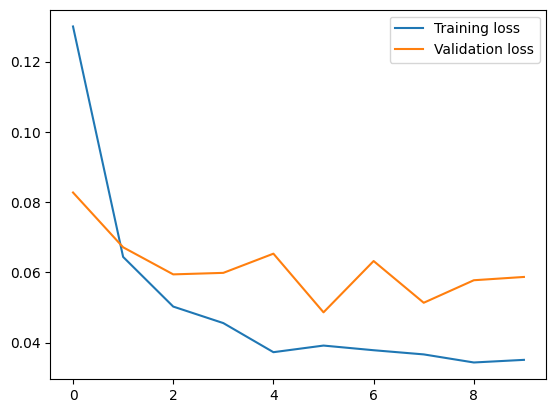

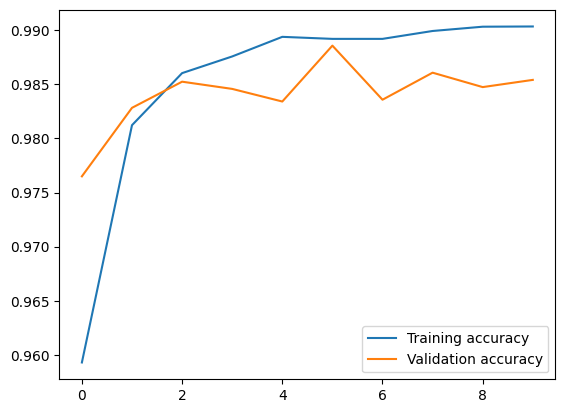

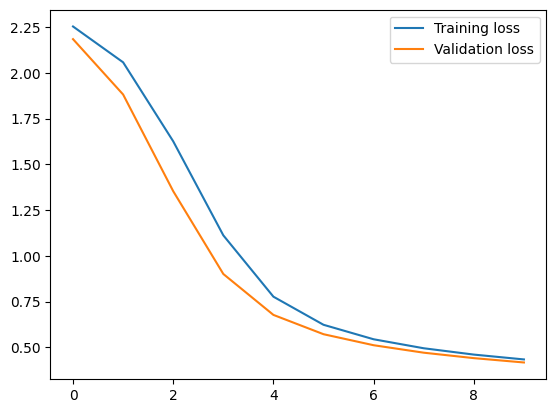

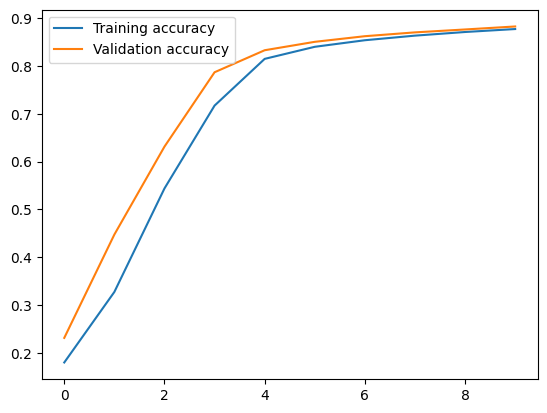

In [ ]:
# funciones proporcionadas para mostrar las gráficas
mostrarEvolucion(historia1)
mostrarEvolucion(historia2)

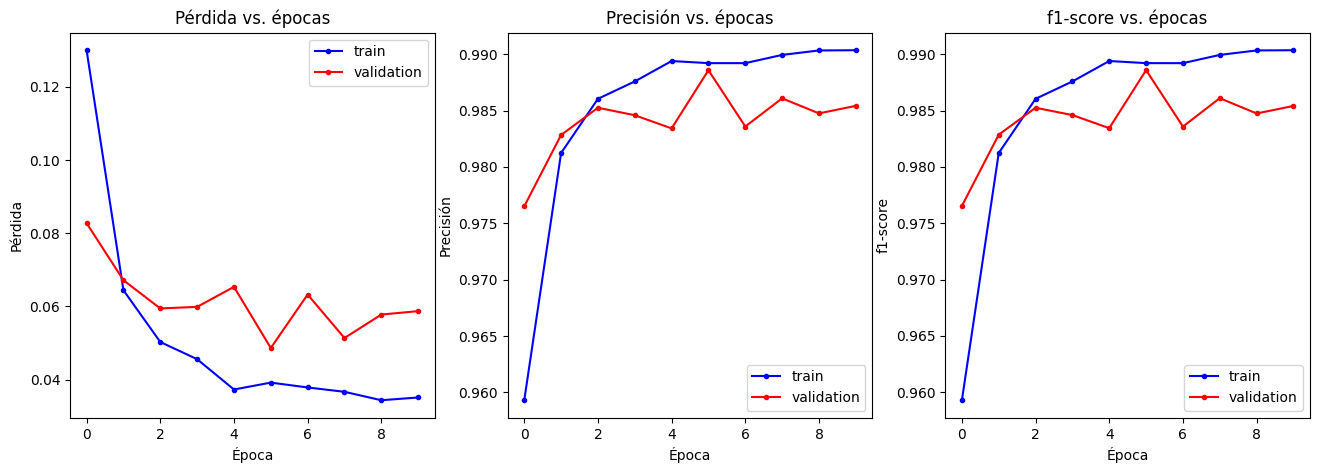

In [ ]:
# gráficas modelo con optimizador adamw

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.plot(historia1.history['loss'], marker='.', color='blue', label='train')
plt.plot(historia1.history['val_loss'], marker='.', color='red', label='validation')
plt.title('Pérdida vs. épocas')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend()

plt.subplot(1,3,2)
plt.plot(historia1.history['accuracy'], marker='.', color='blue', label='train')
plt.plot(historia1.history['val_accuracy'], marker='.', color='red', label='validation')
plt.title('Precisión vs. épocas')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend()

plt.subplot(1,3,3)
plt.plot(historia1.history['f1_score'], marker='.', color='blue', label='train')
plt.plot(historia1.history['val_f1_score'], marker='.', color='red', label='validation')
plt.title('f1-score vs. épocas')
plt.ylabel('f1-score')
plt.xlabel('Época')
plt.legend()

plt.show()

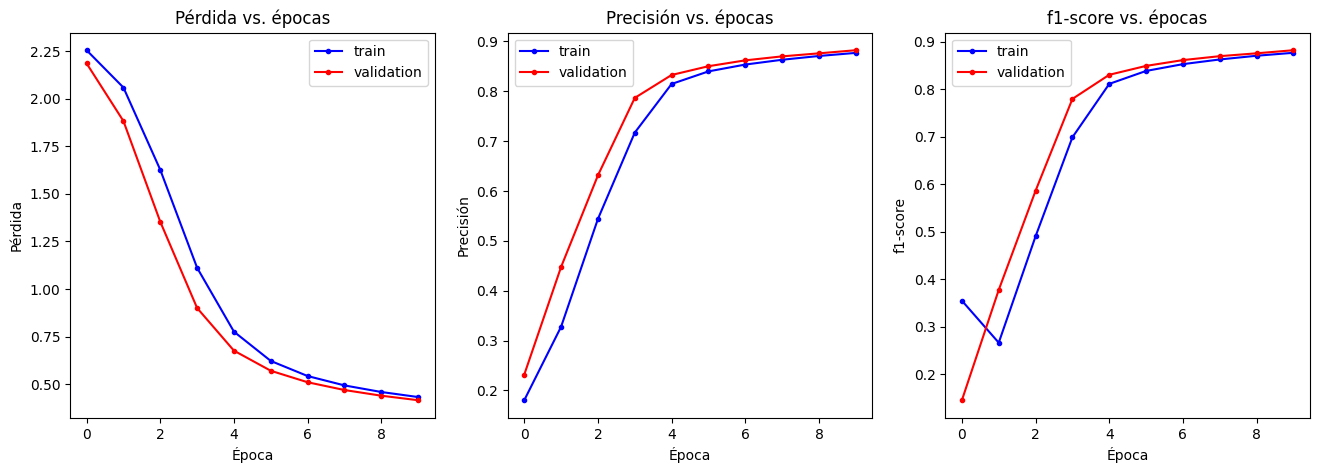

In [ ]:
# gráficas modelo con optimizador adadelta

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.plot(historia2.history['loss'], marker='.', color='blue', label='train')
plt.plot(historia2.history['val_loss'], marker='.', color='red', label='validation')
plt.title('Pérdida vs. épocas')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend()

plt.subplot(1,3,2)
plt.plot(historia2.history['accuracy'], marker='.', color='blue', label='train')
plt.plot(historia2.history['val_accuracy'], marker='.', color='red', label='validation')
plt.title('Precisión vs. épocas')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend()

plt.subplot(1,3,3)
plt.plot(historia2.history['f1_score'], marker='.', color='blue', label='train')
plt.plot(historia2.history['val_f1_score'], marker='.', color='red', label='validation')
plt.title('f1-score vs. épocas')
plt.ylabel('f1-score')
plt.xlabel('Época')
plt.legend()

plt.show()

**Conclusiones de las gráficas**:

En primer lugar, vemos cómo el modelo creado con <u>el optimizador Adadelta genera gráficas más suaves</u>, sin tantos picos como en el modelo del optimizador AdamW. Esto puede deberse a que el optimizador Adadelta proporciona actualizaciones más estables mediante un ajuste dinámico de la tasa de aprendizaje y el uso de una ventana deslizante de gradientes. Este enfoque reduce la variabilidad y produce cambios más consistentes y graduales en los parámetros del modelo. De hecho, en algunos casos, los datos de validación llegan a superar sorprendentemente a los de entrenamiento.

Por otro lado, los <u>picos en las gráficas de AdamW</u> se deben a sus ajustes más rápidos y agresivos, impulsados por momentos de primer y segundo orden. Además, el AdamW usa "weight decay" (decaimiento de peso), lo que ayuda a la generalización y a prevenir el sobreajuste, pero a la vez puede introducir cierta variabilidad adicional en las actualizaciones si el decaimiento no está perfectamente sintonizado con la tasa de aprendizaje, como parece que está pasando. En siguientes apartados se tratará de optimizar el learning-rate del optimizador AdamW.

<u>En el modelo Adadelta las métricas de entrenamiento y validación son bastante parecidas; en el caso de AdamW sí hay más de diferencia</u>, siendo estas un poco más altas en general. Según bibliografía, AdamW tiende a ser más flexible y efectivo en una amplia gama de problemas debido a su capacidad de ajuste de tasas de aprendizaje y correcta implementación del weight decay; mientras que Adadelta se prefiere en situaciones donde la simplicidad y la robustez priman frente a variaciones de gradientes.

En nuestro caso, AdamW ha obtenido mejores resultados, pues nos ofrece un accuracy y f1-score mayores, además de una función de pérdida menor.

Finalmente, vemos cómo <u>a mayor número de épocas obtenemos mejor precisión y f1-score</u>, como cabía esperar. Habrá que buscar un equilibrio entre mayor precisión y número de épocas porque parece que la función de pérdida no baja tanto como esperábamos y, obviamente, a mayor número de épocas más tiempo tendremos que emplear. Estos hiperparámetros buscamos optimizarlos más abajo.

En las siguientes celdas mostramos un **resumen** de las capas que conforman cada modelo. Vemos que ambos modelos tienen la misma estructura, pues así se han definido, y esta coincide con la que nos pide el ejercicio.

In [ ]:
modelAW.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 10, 10, 16)        12816     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 5, 5, 16)          0         
 ng2D)                                                           
                                                                 
 flatten_10 (Flatten)        (None, 400)               0         
                                                                 
 dense_30 (Dense)            (None, 100)             

In [ ]:
modelAD.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 10, 10, 16)        12816     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 5, 5, 16)          0         
 ng2D)                                                           
                                                                 
 flatten_11 (Flatten)        (None, 400)               0         
                                                                 
 dense_33 (Dense)            (None, 100)             

A continuación, procedemos a la **optimización de los hiperparámetros** de las distintas funciones que hemos usado (*tamaño de batch y epochs en el fit; learning_rate en el optimizador*). Para ello, vamos cambiando los valores de dichos hiperparámetros manualmente razonando el por qué del cambio.

En el primer cambio, modificamos el batch_size a 20, aumentándolo. El resto de parámetros no los movemos.

In [ ]:
# Reestablecemos los pesos iniciales, previos al entrenamiento ya hecho
modelAW.set_weights(weightsAW)
modelAD.set_weights(weightsAD)

# cambiamos los parámetros del método fit: solo aumentamos el núm de batch (dejamos el learning-rate como estaba por defecto)
nbatch = 20
nepochs = 10
callback = EarlyStopping(monitor='accuracy', patience=3)    # regularización

historia1 = modelAW.fit( x=X_train, y=Y_train, batch_size=nbatch, epochs=nepochs, callbacks=[callback], validation_data=(x_vali, y_vali) )
historia2 = modelAD.fit( x=X_train, y=Y_train, batch_size=nbatch, epochs=nepochs, callbacks=[callback], validation_data=(x_vali, y_vali) )

Epoch 1/10
2400/2400 [==============================] - 14s 6ms/step - loss: 0.1531 - accuracy: 0.9520 - f1_score: 0.9520 - val_loss: 0.0645 - val_accuracy: 0.9792 - val_f1_score: 0.9792
Epoch 2/10
2400/2400 [==============================] - 16s 7ms/step - loss: 0.0518 - accuracy: 0.9833 - f1_score: 0.9833 - val_loss: 0.0503 - val_accuracy: 0.9842 - val_f1_score: 0.9842
Epoch 3/10
2400/2400 [==============================] - 18s 8ms/step - loss: 0.0378 - accuracy: 0.9879 - f1_score: 0.9879 - val_loss: 0.0431 - val_accuracy: 0.9871 - val_f1_score: 0.9871
Epoch 4/10
2400/2400 [==============================] - 12s 5ms/step - loss: 0.0293 - accuracy: 0.9906 - f1_score: 0.9906 - val_loss: 0.0414 - val_accuracy: 0.9877 - val_f1_score: 0.9877
Epoch 5/10
2400/2400 [==============================] - 13s 6ms/step - loss: 0.0238 - accuracy: 0.9925 - f1_score: 0.9925 - val_loss: 0.0352 - val_accuracy: 0.9898 - val_f1_score: 0.9897
Epoch 6/10
2400/2400 [==============================] - 17s 7ms/s

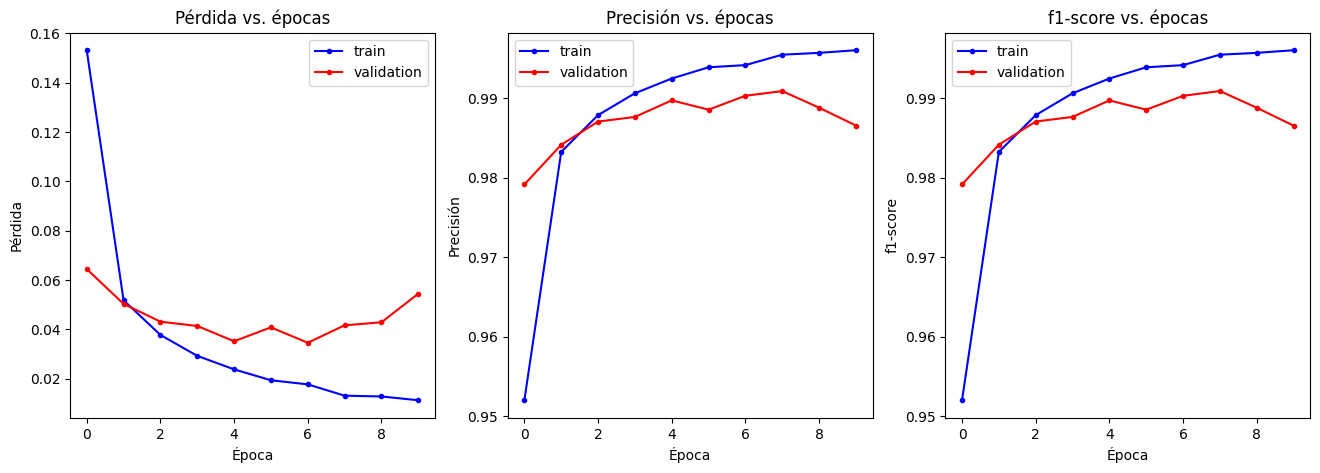

In [ ]:
# gráficas modelo con optimizador adamw

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.plot(historia1.history['loss'], marker='.', color='blue', label='train')
plt.plot(historia1.history['val_loss'], marker='.', color='red', label='validation')
plt.title('Pérdida vs. épocas')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend()

plt.subplot(1,3,2)
plt.plot(historia1.history['accuracy'], marker='.', color='blue', label='train')
plt.plot(historia1.history['val_accuracy'], marker='.', color='red', label='validation')
plt.title('Precisión vs. épocas')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend()

plt.subplot(1,3,3)
plt.plot(historia1.history['f1_score'], marker='.', color='blue', label='train')
plt.plot(historia1.history['val_f1_score'], marker='.', color='red', label='validation')
plt.title('f1-score vs. épocas')
plt.ylabel('f1-score')
plt.xlabel('Época')
plt.legend()

plt.show()

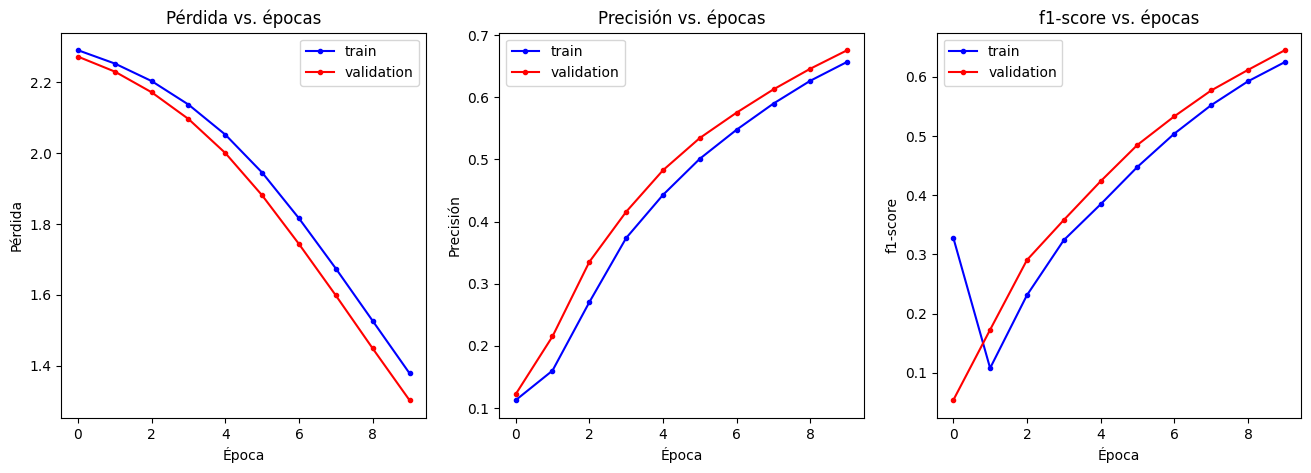

In [ ]:
# gráficas modelo con optimizador adadelta

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.plot(historia2.history['loss'], marker='.', color='blue', label='train')
plt.plot(historia2.history['val_loss'], marker='.', color='red', label='validation')
plt.title('Pérdida vs. épocas')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend()

plt.subplot(1,3,2)
plt.plot(historia2.history['accuracy'], marker='.', color='blue', label='train')
plt.plot(historia2.history['val_accuracy'], marker='.', color='red', label='validation')
plt.title('Precisión vs. épocas')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend()

plt.subplot(1,3,3)
plt.plot(historia2.history['f1_score'], marker='.', color='blue', label='train')
plt.plot(historia2.history['val_f1_score'], marker='.', color='red', label='validation')
plt.title('f1-score vs. épocas')
plt.ylabel('f1-score')
plt.xlabel('Época')
plt.legend()

plt.show()

Como primera diferencia respecto al anterior entrenamiento mencionamos que al aumentar el número de batch estamos disminuyendo el tiempo que tarda el entrenamiento por cada época. De esta forma, preferimos un número de batch alto frente a bajo. En cuanto al modelo AdamW, vemos cómo es en la época 7 cuando se obtiene un mayor valor de val_accuracy; a partir de esta época, la precisión en entrenamiento sigue subiendo pero no la de validación (empieza a haber sobreajuste). Por tanto, deducimos que el mejor número de épocas para AdamW es 7, combinado con batch_size=20. En el siguiente entrenamiento ajustamos con esos parámetros.

Por otro lado, en cuanto al modelo Adadelta, ahora estamos obteniendo peores resultados. Vemos que éste se comportaba mejor con un menor número de batch, no obstante preferimos subir este número y también incrementar el número de épocas, pues vemos que la línea es creciente tanto en training como en validation. En el siguiente entrenamiento vamos a probar con batch_size=20 pues nos interesa que vaya rápido el modelo ante todo, pero con un número de épocas mayor (epochs=50), quizás así consigamos mejores resultados.

In [ ]:
# Reestablecemos los pesos iniciales, previos al entrenamiento ya hecho
modelAW.set_weights(weightsAW)
modelAD.set_weights(weightsAD)

# cambiamos los parámetros del método fit: solo modificamos el núm de batch, aumentándolo (dejamos el learning-rate como estaba por defecto)
callback = EarlyStopping(monitor='accuracy', patience=3)    # regularización

historia1 = modelAW.fit( x=X_train, y=Y_train, batch_size=20, epochs=7, callbacks=[callback], validation_data=(x_vali, y_vali) )
historia2 = modelAD.fit( x=X_train, y=Y_train, batch_size=60, epochs=50, callbacks=[callback], validation_data=(x_vali, y_vali) )

Epoch 1/7
2400/2400 [==============================] - 12s 5ms/step - loss: 0.1464 - accuracy: 0.9538 - f1_score: 0.9538 - val_loss: 0.0650 - val_accuracy: 0.9808 - val_f1_score: 0.9808
Epoch 2/7
2400/2400 [==============================] - 16s 7ms/step - loss: 0.0536 - accuracy: 0.9828 - f1_score: 0.9828 - val_loss: 0.0565 - val_accuracy: 0.9820 - val_f1_score: 0.9820
Epoch 3/7
2400/2400 [==============================] - 16s 7ms/step - loss: 0.0385 - accuracy: 0.9876 - f1_score: 0.9876 - val_loss: 0.0457 - val_accuracy: 0.9864 - val_f1_score: 0.9864
Epoch 4/7
2400/2400 [==============================] - 14s 6ms/step - loss: 0.0302 - accuracy: 0.9902 - f1_score: 0.9902 - val_loss: 0.0480 - val_accuracy: 0.9860 - val_f1_score: 0.9860
Epoch 5/7
2400/2400 [==============================] - 15s 6ms/step - loss: 0.0240 - accuracy: 0.9921 - f1_score: 0.9921 - val_loss: 0.0361 - val_accuracy: 0.9893 - val_f1_score: 0.9892
Epoch 6/7
2400/2400 [==============================] - 12s 5ms/step - 

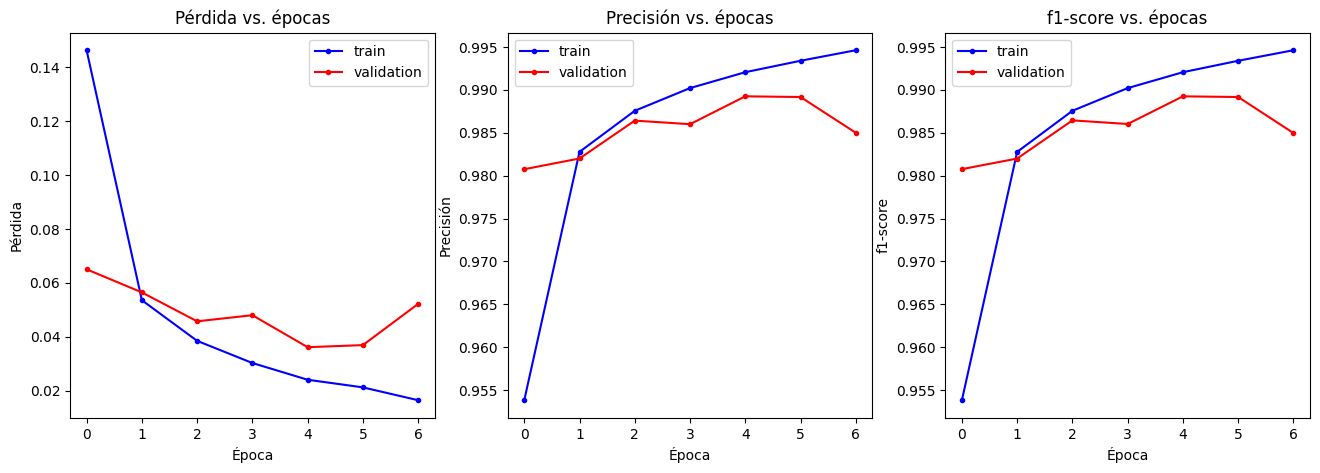

In [ ]:
# gráficas modelo con optimizador adamw

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.plot(historia1.history['loss'], marker='.', color='blue', label='train')
plt.plot(historia1.history['val_loss'], marker='.', color='red', label='validation')
plt.title('Pérdida vs. épocas')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend()

plt.subplot(1,3,2)
plt.plot(historia1.history['accuracy'], marker='.', color='blue', label='train')
plt.plot(historia1.history['val_accuracy'], marker='.', color='red', label='validation')
plt.title('Precisión vs. épocas')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend()

plt.subplot(1,3,3)
plt.plot(historia1.history['f1_score'], marker='.', color='blue', label='train')
plt.plot(historia1.history['val_f1_score'], marker='.', color='red', label='validation')
plt.title('f1-score vs. épocas')
plt.ylabel('f1-score')
plt.xlabel('Época')
plt.legend()

plt.show()

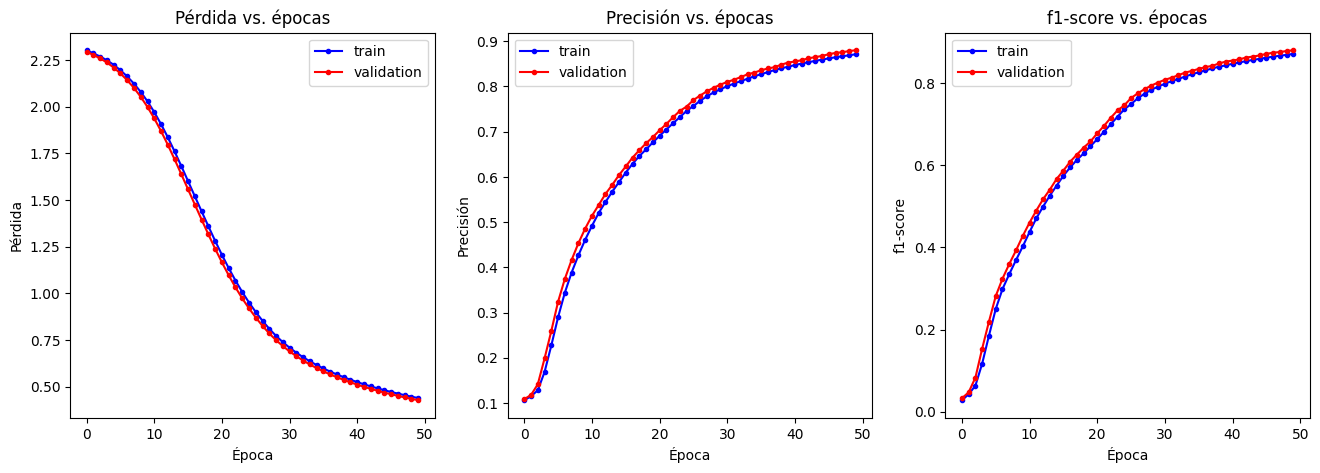

In [ ]:
# gráficas modelo con optimizador adadelta

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.plot(historia2.history['loss'], marker='.', color='blue', label='train')
plt.plot(historia2.history['val_loss'], marker='.', color='red', label='validation')
plt.title('Pérdida vs. épocas')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend()

plt.subplot(1,3,2)
plt.plot(historia2.history['accuracy'], marker='.', color='blue', label='train')
plt.plot(historia2.history['val_accuracy'], marker='.', color='red', label='validation')
plt.title('Precisión vs. épocas')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend()

plt.subplot(1,3,3)
plt.plot(historia2.history['f1_score'], marker='.', color='blue', label='train')
plt.plot(historia2.history['val_f1_score'], marker='.', color='red', label='validation')
plt.title('f1-score vs. épocas')
plt.ylabel('f1-score')
plt.xlabel('Época')
plt.legend()

plt.show()

Efectivamente, el modelo Adadelta ha mejorado su precisión y fitness. Podemos decir que no nos conviene aumentar el número de épocas porque parece que ha llegado a una asíntota horizontal y que mejorará muy lentamente. **Mejores parámetros para Adadelta: batch_size=60, nepochs=50, learning_rate=0.001**.

Sin embargo, en el modelo AdamW no hemos mejorado los resultados. Vamos a probar en el siguiente entrenamiento a modificar el learning-rate, dejando batch_size=20 y epochs=10. Pues como indicamos anteriormente, es muy importante en AdamW tener un buen equilibrio entre learning_rate y el weight decay que usa internamente.

In [ ]:
# Reestablecemos los pesos iniciales, previos al entrenamiento ya hecho
modelAW.set_weights(weightsAW)

# aumentamos el learning-rate del optimizador, pasando de 0.001 a 0.01
metric_f1= F1Score(name="f1_score", average='weighted')
modelAW.compile(loss="categorical_crossentropy", metrics=['accuracy', metric_f1], optimizer=AdamW(learning_rate=0.01))

# mantenemos los parámetros del fit del segundo entrenamiento
callback = EarlyStopping(monitor='accuracy', patience=3)
historia1 = modelAW.fit( x=X_train, y=Y_train, batch_size=20, epochs=10, callbacks=[callback], validation_data=(x_vali, y_vali) )

Epoch 1/10
2400/2400 [==============================] - 14s 5ms/step - loss: 0.1824 - accuracy: 0.9473 - f1_score: 0.9473 - val_loss: 0.1023 - val_accuracy: 0.9713 - val_f1_score: 0.9713
Epoch 2/10
2400/2400 [==============================] - 13s 6ms/step - loss: 0.1202 - accuracy: 0.9691 - f1_score: 0.9691 - val_loss: 0.1018 - val_accuracy: 0.9777 - val_f1_score: 0.9776
Epoch 3/10
2400/2400 [==============================] - 12s 5ms/step - loss: 0.1134 - accuracy: 0.9729 - f1_score: 0.9729 - val_loss: 0.0893 - val_accuracy: 0.9798 - val_f1_score: 0.9798
Epoch 4/10
2400/2400 [==============================] - 13s 5ms/step - loss: 0.1102 - accuracy: 0.9744 - f1_score: 0.9744 - val_loss: 0.0929 - val_accuracy: 0.9772 - val_f1_score: 0.9772
Epoch 5/10
2400/2400 [==============================] - 13s 5ms/step - loss: 0.1043 - accuracy: 0.9761 - f1_score: 0.9761 - val_loss: 0.1091 - val_accuracy: 0.9793 - val_f1_score: 0.9793
Epoch 6/10
2400/2400 [==============================] - 12s 5ms/s

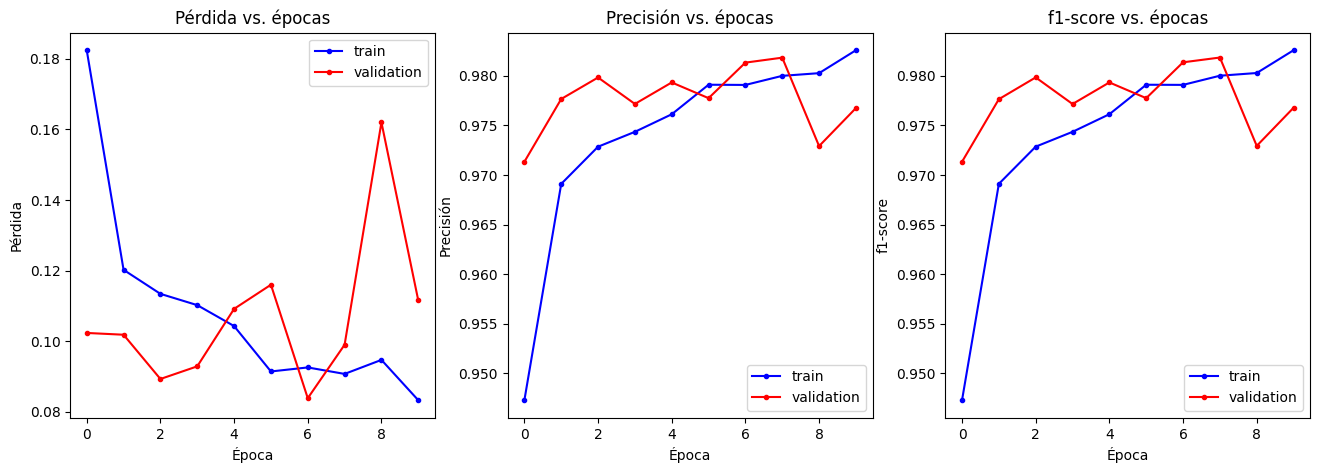

In [ ]:
# gráficas modelo con optimizador adamw

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.plot(historia1.history['loss'], marker='.', color='blue', label='train')
plt.plot(historia1.history['val_loss'], marker='.', color='red', label='validation')
plt.title('Pérdida vs. épocas')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend()

plt.subplot(1,3,2)
plt.plot(historia1.history['accuracy'], marker='.', color='blue', label='train')
plt.plot(historia1.history['val_accuracy'], marker='.', color='red', label='validation')
plt.title('Precisión vs. épocas')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend()

plt.subplot(1,3,3)
plt.plot(historia1.history['f1_score'], marker='.', color='blue', label='train')
plt.plot(historia1.history['val_f1_score'], marker='.', color='red', label='validation')
plt.title('f1-score vs. épocas')
plt.ylabel('f1-score')
plt.xlabel('Época')
plt.legend()

plt.show()

Aumentando el learning-rate obtenemos unos resultados aún más variables que en los entrenamientos anteriores. Probamos ahora disminuyendo el learning rate en lugar de aumentarlo. Además, también aumentamos tanto el número de batch como el de épocas, pues a mayor épocas estamos obteniendo mejor accuracy y f1-score en general.

In [ ]:
# Reestablecemos los pesos iniciales, previos al entrenamiento ya hecho
modelAW.set_weights(weightsAW)

# disminuimos el learning-rate del optimizador, pasando de 0.001 a 0.0001
metric_f1= F1Score(name="f1_score", average='weighted')
modelAW.compile(loss="categorical_crossentropy", metrics=['accuracy', metric_f1], optimizer=AdamW(learning_rate=0.0001))

# mantenemos los parámetros del fit del segundo entrenamiento
callback = EarlyStopping(monitor='accuracy', patience=3)
historia1 = modelAW.fit( x=X_train, y=Y_train, batch_size=30, epochs=20, callbacks=[callback], validation_data=(x_vali, y_vali) )

Epoch 1/20
1600/1600 [==============================] - 11s 6ms/step - loss: 0.5412 - accuracy: 0.8414 - f1_score: 0.8420 - val_loss: 0.2212 - val_accuracy: 0.9346 - val_f1_score: 0.9343
Epoch 2/20
1600/1600 [==============================] - 8s 5ms/step - loss: 0.1616 - accuracy: 0.9517 - f1_score: 0.9517 - val_loss: 0.1284 - val_accuracy: 0.9620 - val_f1_score: 0.9620
Epoch 3/20
1600/1600 [==============================] - 9s 6ms/step - loss: 0.1122 - accuracy: 0.9663 - f1_score: 0.9662 - val_loss: 0.1056 - val_accuracy: 0.9680 - val_f1_score: 0.9680
Epoch 4/20
1600/1600 [==============================] - 9s 5ms/step - loss: 0.0899 - accuracy: 0.9729 - f1_score: 0.9729 - val_loss: 0.0837 - val_accuracy: 0.9750 - val_f1_score: 0.9750
Epoch 5/20
1600/1600 [==============================] - 10s 6ms/step - loss: 0.0767 - accuracy: 0.9766 - f1_score: 0.9766 - val_loss: 0.0747 - val_accuracy: 0.9781 - val_f1_score: 0.9781
Epoch 6/20
1600/1600 [==============================] - 11s 7ms/step

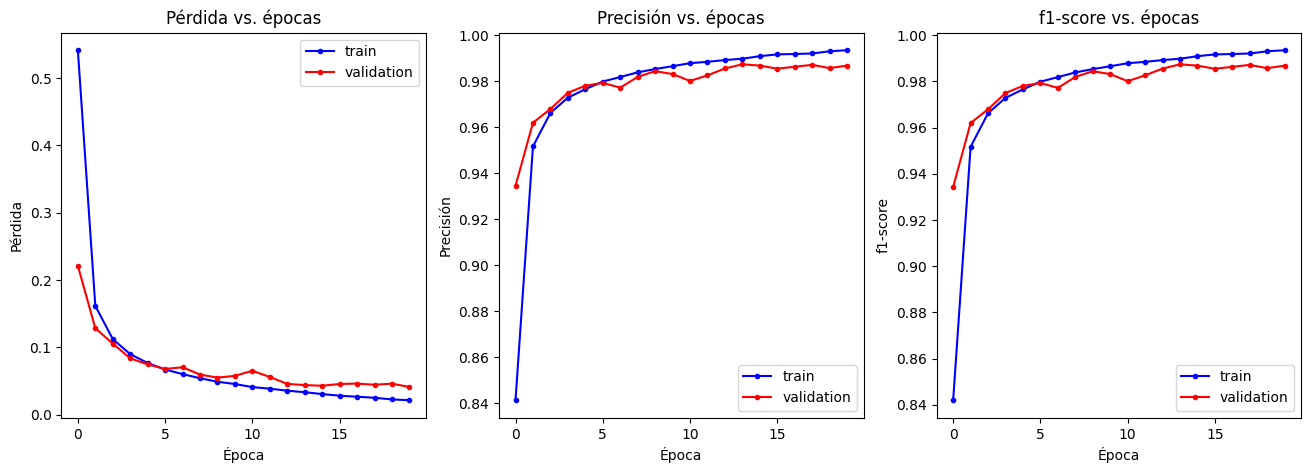

In [ ]:
# gráficas modelo con optimizador adamw

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.plot(historia1.history['loss'], marker='.', color='blue', label='train')
plt.plot(historia1.history['val_loss'], marker='.', color='red', label='validation')
plt.title('Pérdida vs. épocas')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend()

plt.subplot(1,3,2)
plt.plot(historia1.history['accuracy'], marker='.', color='blue', label='train')
plt.plot(historia1.history['val_accuracy'], marker='.', color='red', label='validation')
plt.title('Precisión vs. épocas')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend()

plt.subplot(1,3,3)
plt.plot(historia1.history['f1_score'], marker='.', color='blue', label='train')
plt.plot(historia1.history['val_f1_score'], marker='.', color='red', label='validation')
plt.title('f1-score vs. épocas')
plt.ylabel('f1-score')
plt.xlabel('Época')
plt.legend()

plt.show()

Con este entrenamiento podemos decir que hemos encontrado el learning-rate óptimo para nuestro optimizador AdamW; ahora no obtenemos los picos del principio. Además, también podemos decir que hemos encontrado una asíntota horizontal y que por tanto, no vamos a mejorar significativamente la precisión al aumentar el número de épocas. Por tanto, **los mejores valores de los hiperparámetros que hemos encontrado para AdamW son: learning_rate=0.0001, batch_size=30, epochs=20**.

Finalmente, evaluamos la mejor versión encontrada para los dos modelos. Usamos datos del **conjunto de test** y empleamos la función **evaluate** de keras. Al final, también llamamos a la función proporcionada por los profesores para calcular el accuracy de cada modelo.

In [ ]:
# métricas en el conjunto de test
score1 = modelAW.evaluate(x_test, y_test, verbose=0)
score2 = modelAD.evaluate(x_test, y_test, verbose=0)

tabla = [['Modelo con AdamW      ', score1[0], score1[1], score1[2]],
         ['Modelo con Adadelta   ', score2[0], score2[1], score2[2]]]

print("MÉTRICAS EN EL CONJUNTO DE TEST\n")
print(tabulate(tabla, headers=['Modelo', 'Loss', 'Accuracy', 'f1-score']))

Modelo                    Loss    Accuracy    f1-score
-------------------  ---------  ----------  ----------
Modelo con AdamW     0.0366119      0.9876    0.987608
Modelo con Adadelta  0.417561       0.8795    0.879328


In [ ]:
calcularAccuracy(y_test, modelAW.predict(x_test))

313/313 [==============================] - 1s 2ms/step


0.9861

In [ ]:
calcularAccuracy(y_test, modelAD.predict(x_test))

313/313 [==============================] - 1s 2ms/step


0.886

Concluimos cómo **el modelo con optimizador AdamW ha generalizado mejor a los datos de test respecto al modelo del Adadelta**. Esto se debe a que el AdamW suele generalizar mejor gracias al weight decay que aplica en su modo de proceder.

## <font color='blue'> Apartado 2. Implementación y experimentación con técnicas clásicas (características HOG y SVMs) (2 puntos)

<font color='blue'> Ahora vamos a emplear SVM y características de HOG para clasificar estas imágenes. Se debe describir todo el proceso de ajuste realizado, incluyendo la selección de hiperparámetros, y se deben discutir las ventajas y desventajas de esta aproximación en comparación con el uso de _deep learning_, así como los resultados obtenidos y la calidad de las características empleadas.

In [1]:
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import f1_score, accuracy_score

In [4]:
from skimage.feature import hog

fd = hog(x_train[0], orientations=4, pixels_per_cell=(10,10), cells_per_block=(2, 2), visualize=False, channel_axis=-1)

x_train_HOG = np.zeros((x_train.shape[0],len(fd)), np.float32)
x_test_HOG = np.zeros((x_test.shape[0],len(fd)), np.float32)

for i in range(x_train.shape[0]):
  x_train_HOG[i] = hog(x_train[i], orientations=4, pixels_per_cell=(10, 10), cells_per_block=(2, 2), visualize=False, channel_axis=-1)
for i in range(x_test.shape[0]):
  x_test_HOG[i] = hog(x_test[i], orientations=4, pixels_per_cell=(10, 10), cells_per_block=(2, 2), visualize=False, channel_axis=-1)

In [ ]:
print(x_train_HOG.shape) # mediante HOG obtenemos 16 características para los 60000 ejemplos de entrenamiento

(60000, 16)


Mediante **HOG** estamos considerando 16 características; mientras que la red neuronal anterior extraía 400 atributos del conjunto de entrenamiento en su fase de *feature learning* y luego esas características las recibía la fase de *classification*. Todo ello de forma más optimizada que haciendo ambas fases por separado como en este apartado. No obstante, para hacer los cálculos de deep learning necesitamos más recursos computacionales (GPU) que para las técnicas clásicas.

Brevemente, mencionar por qué se extraen 400 características usando redes neuronales. Según construimos la red neuronal, la capa flatten es la que se sitúa en medio de ambas fases. Su función es transformar la salida tridimensional de la última capa convolucional o de pooling en un vector unidimensional. En este caso, la salida de la capa de pooling anterior es una matriz de $5\times5\times16$, que tiene un total de $5*5*16 = 400$ elementos.

Para este apartado, necesitamos revertir el proceso de convertir las etiquetas en una matriz. Esto nos interesaba para las redes neuronales, pero no para los clasificadores SVM, donde queremos que sean un vector de tamaño número de ejemplos.

In [6]:
# Pasamos de tener las etiquetas en forma de matriz a vectores
y_train_vec = np.argmax(y_train, axis=1)
y_test_vec = np.argmax(y_test, axis=1)

print(y_train_vec.shape)
print(y_test_vec.shape)

(60000,)
(10000,)


Vamos a utilizar el **clasificador SVC de scikit-learn**. Es cierto que el LinearSVC es más rápido que el SVC y que para conjuntos de datos grandes podría ir mejor; pero también puede interesarnos a priori que el núcleo sea no lineal. Por ello, hacemos dos pruebas iniciales con SVC de tipo kernel lineal y C=100; y kernel sigmoide con C=10.

In [8]:
# construimos un clasificador SVM lineal
# hiperparámetro de regularización C inicializado a 100, kernel lineal y gamma por defecto a "scale" (1 / (n_features * X.var()))
# entrenamiento con los datos de entrenamiento
svcModel = SVC(kernel="linear", C=100, random_state=42)
svcModel.fit(x_train_HOG, y_train_vec)

# validación empleando cross-validation con 5 capas, se obtiene la precisión media en validation y training
svc_metrics = cross_validate(svcModel, x_train_HOG, y_train_vec, return_train_score=True, cv=5)
svc_val_acc  = np.mean(svc_metrics.get('test_score'))
svc_train_acc = np.mean(svc_metrics.get('train_score'))
print("Train accuracy       = ", svc_train_acc)
print("Validation accuracy  = ", svc_val_acc)

Train accuracy       =  0.802875
Validation accuracy  =  0.7997833333333334


In [7]:
# construimos un clasificador SVM sigmoide
# hiperparámetro de regularización C inicializado a 10, kernel sigmoid y gamma por defecto a "scale" (1 / (n_features * X.var()))
# entrenamiento con los datos de entrenamiento
svcModelS = SVC(kernel="sigmoid", C=10, random_state=42)
svcModelS.fit(x_train_HOG, y_train_vec)

# validación empleando cross-validation con 5 capas, se obtiene la precisión media en validation y training
svc_metrics = cross_validate(svcModelS, x_train_HOG, y_train_vec, return_train_score=True, cv=5)
svc_val_acc  = np.mean(svc_metrics.get('test_score'))
svc_train_acc = np.mean(svc_metrics.get('train_score'))
print("Train accuracy       = ", svc_train_acc)
print("Validation accuracy  = ", svc_val_acc)

Train accuracy =        0.4535333333333333
Validation accuracy  =  0.4535


Con el clasificador SVM lineal obtenemos una **precisión del ~80%**, siendo ligeramente peor que las redes neuronales. Y también ha tardado bastante más: 10 minutos el SVM, frente a unos 3 minutos con deep learning. El segundo modelo, basado en un kernel sigmoide, aparte de tardar aún más (casi media hora), obtiene peores resultados, por lo que no lo consideramos en las optimizaciones futuras. **El kernel lineal es el que más conviene**.

Como se trata de un conjunto de datos muy grande, vamos a utilizar el **LinearSVC** para poder optimizar el hiperparámetro de regularización de forma más eficiente para el caso del comportamiento lineal.

LinearSVC se basa en el SVM con kernel lineal pero está más optimizado. Además, está implementado en términos de liblinear en lugar de libsvm, lo que da más flexibilidad en la elección de penalizaciones y funciones de pérdida, traduciéndose en un mejor escalado a una gran cantidad de muestras, como es el caso. Las principales diferencias entre LinearSVC y SVC radican en la función de pérdida utilizada de forma predeterminada y en el manejo de la regularización de intercepción entre esas dos implementaciones.

En primer lugar, ejecutamos un **LinearSVC con los parámetros por defecto**:

*   penalty="l2"         --> se utiliza la norma euclídea para la penalización
*   loss="squared_hinge" --> función de pérdida
*   tol=1e-4             --> tolerancia para el criterio de parada
*   C=1                  --> por defecto, la regularización es 1

In [ ]:
linearSVC = LinearSVC(random_state=42, C=1.0) # todos los parámetros por defecto
linearSVC.fit(x_train_HOG, y_train_vec)

# validación empleando cross-validation con 5 capas, se obtiene la precisión media en validation y training
linearSVC_metrics = cross_validate(linearSVC, x_train_HOG, y_train_vec, return_train_score=True, cv=5)
linearSVC_val_acc  = np.mean(linearSVC_metrics.get('test_score'))
linearSVC_train_acc = np.mean(linearSVC_metrics.get('train_score'))
print("Train accuracy =       ", linearSVC_train_acc)
print("Validation accuracy  = ", linearSVC_val_acc)

Train accuracy =        0.7653583333333334
Validation accuracy  =  0.7638333333333334


Hemos obtenido resultados ligeramente peores frente al SVC con kernel lineal, pero a la vez, ha sido mucho más rápido (26 segundos en lugar de 10 minutos). Nos interesa la rapidez para emplear una optimización de hiperparámetros eficiente. Ahora tratamos de mejorar este modelo optimizando el parámetro de regularización C con **GridSearchCV**.

In [ ]:
# GridSearch basado en validación cruzada aplicado a LinearSVC
# variamos el parámetro C
svm_params = [{'C' : [0.1, 1, 10, 100]}]

svm_grid = GridSearchCV( estimator = LinearSVC(random_state=42),
                     param_grid = svm_params,
                     scoring = 'accuracy',
                     cv = RepeatedKFold(n_splits = 3),
                     n_jobs = -1 )

svm_grid.fit(x_train_HOG, y_train_vec) # entrenamos cada modelo

cvres = svm_grid.cv_results_

for mean_test_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    # imprimimos la precisión media junto a los params por cada iteración
    print(np.mean(mean_test_score), params)

# imprimimos el mejor resultado con sus hiperparámetros asociados
print("\nMejor resultado:")
print(svm_grid.best_params_)
print(svm_grid.best_score_)

0.75873 {'C': 0.1}
0.7642566666666667 {'C': 1}
0.7651066666666666 {'C': 10}
0.7633483333333333 {'C': 100}

Mejor resultado:
{'C': 10}
0.7651066666666666


**El mejor valor del hiperparámetro C de los estudiados es 10**, pero vemos que no llega a mejorar al SVC con kernel lineal. A continuación creamos el modelo LinealSVC con C=10.

In [9]:
linearSVC = LinearSVC(random_state=42, C=10) # todos los parámetros por defecto
linearSVC.fit(x_train_HOG, y_train_vec)

# validación empleando cross-validation con 5 capas, se obtiene la precisión media en validation y training
linearSVC_metrics = cross_validate(linearSVC, x_train_HOG, y_train_vec, return_train_score=True, cv=5)
linearSVC_val_acc  = np.mean(linearSVC_metrics.get('test_score'))
linearSVC_train_acc = np.mean(linearSVC_metrics.get('train_score'))
print("Train accuracy =       ", linearSVC_train_acc)
print("Validation accuracy  = ", linearSVC_val_acc)

Train accuracy =        0.7659166666666666
Validation accuracy  =  0.7646833333333334


Calculamos las métricas de accuracy y f1-score de los modelos entrenados en el **conjunto de test**.

In [12]:
# predicciones
y_pred_linearSVC = linearSVC.predict(x_test_HOG)
y_pred_svc_lin   = svcModel.predict(x_test_HOG)

# accuracy
ac_linearSVC = accuracy_score(y_test_vec, y_pred_linearSVC)
ac_svc_lin   = accuracy_score(y_test_vec, y_pred_svc_lin)

# f1-score (average=weighted por ser un clasificador no binario)
f1_linearSVC = f1_score(y_test_vec, y_pred_linearSVC, average='weighted')
f1_svc_lin   = f1_score(y_test_vec, y_pred_svc_lin, average='weighted')

tabla = [['SVC lineal   (C=100) ', ac_linearSVC, f1_linearSVC],
         ['LinearSVC    (C=10)  ', ac_svc_lin,     f1_svc_lin]]

print("MÉTRICAS EN EL CONJUNTO DE TEST\n")
print(tabulate(tabla, headers=['Modelo', 'Accuracy', 'f1-score']))

MÉTRICAS EN EL CONJUNTO DE TEST

Modelo                  Accuracy    f1-score
--------------------  ----------  ----------
SVC lineal   (C=100)      0.7776    0.775078
LinearSVC    (C=10)       0.8106    0.810431


**Conclusiones apartado 2**:

Tras muchos experimentos e intentos de optimizar el modelo SVC, hemos obtenido como mejor resultado una **precisión del 80%**. Cabe destacar cómo el modelo LinearSVC ha superado al SVC lineal en los datos de test, pese a haber sido peor en el entrenamiento.

Todo este proceso nos ha llevado mucho tiempo de cálculo y de prueba y error; mientras que el modelo de deep learning del apartado anterior superó el 98% de precisión tras un proceso de creación y optimización más corto y eficiente. <u>Teniendo los suficientes recursos computacionales, las redes neuronales son la mejor opción</u>.

## <font color='blue'> Apartado 3. Implementación y experimentación con uno o más modelos escogidos o diseñados por los estudiantes (2 puntos)

<font color='blue'> En este apartado, los alumnos deben diseñar su propia red neuronal para intentar mejorar los resultados obtenidos hasta el momento. Por ejemplo, se puede incrementar la profundidad de la red, el número o tamaño de los filtros convolucionales a aprender, se puede optar por emplear técnicas de regularización como Dropout o Batch Normalization, estrategias de _data augmentation_ o inicialización de pesos, etc. Queda a su elección la estrategia a seguir aunque, en cualquier caso, se valorará la complejidad de la propuesta realizada así como la calidad de la documentación aportada.

<font color='blue'> Del mismo modo, los estudiantes también pueden incluir una comparativa con el rendimiento de alguna otra técnica clásica de su elección (como Random Forest o Gradient Boosting) junto con vectores de características de su elección (incluyendo la modificación de los hiperparámetros del extractor de HOG usado en el apartado anterior, para lo cual será necesario que los alumnos revisen la documentación al respecto).

<font color='blue'> Dentro de este tercer apartado, en caso de que se haya saturado el rendimiento en MNIST (en el sentido de obtener una _accuracy_ en validación superior al $98\%$), se debe emplear como conjunto de datos $\textit{CIFAR-10}$ (https://archive.ics.uci.edu/dataset/691/cifar+10 y https://www.cs.toronto.edu/~kriz/cifar.html). Este conjunto de datos contiene información sobre 10 clases de imágenes diferentes, y también está incluido directamente en Keras (https://keras.io/api/datasets/):

```
# Cargar el conjunto de datos CIFAR-10
cifar10 = tf.keras.datasets.cifar10

# Dividir los datos en entrenamiento y prueba
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Clases en CIFAR-10
class_names = ['Avión', 'Coche', 'Pájaro', 'Gato', 'Ciervo',
               'Perro', 'Rana', 'Caballo', 'Barco', 'Camión']
```

Cargamos el **conjunto de datos CIFAR-10**. Dividimos los datos en entrenamiento (40000), validación (10000) y prueba (10000) y los retocamos para que puedan ser tratados por una red neuronal como en el primer apartado.

In [ ]:
# dividimos los datos en entrenamiento y prueba
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# clases en CIFAR-10
class_names = ['Avión', 'Coche', 'Pájaro', 'Gato', 'Ciervo',
               'Perro', 'Rana', 'Caballo', 'Barco', 'Camión']

170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
# NÚMERO DE CLASES
num_classes = 10

# DIMENSIONES DE ENTRADA DE LAS IMAGENES
img_rows, img_cols = 32, 32

# según el orden en el formato de la imagen
# número de canales: 3 pq son imágenes a color (RGB)
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

# FORMATEAMOS Y NORMALIZAMOS LOS DATOS
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Transformamos los vectores de clases en matrices.
# Cada componente se convierte en un vector de ceros
# con un uno en la componente correspondiente a la
# clase a la que pertenece la imagen. Este paso es
# necesario para la clasificación multiclase en keras.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
# separamos los datos de entrenamiento en train y validation de forma estratificada
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
X_train = []
x_vali = []
Y_train = []
y_vali = []

for i, (train_index, vali_index) in enumerate(sss.split(x_train, y_train)):
  X_train = x_train[train_index]
  x_vali = x_train[vali_index]
  Y_train = y_train[train_index]
  y_vali = y_train[vali_index]

In [ ]:
print(X_train.shape[0], 'train samples')      # número de imágenes del conjunto de entrenamiento
print(x_vali.shape[0], 'validation samples')  # número de imágenes del conjunto de test

40000 train samples
10000 validation samples


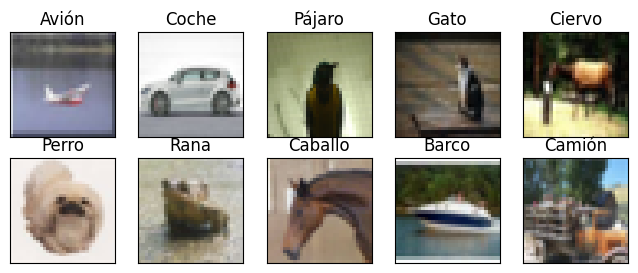

In [ ]:
# visualizamos algunas imágenes de cada clase
fig = plt.figure(figsize=(8,3))
for i in range(len(class_names)):
  ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
  idx = np.where(y_train[:]==i)[0]
  features_idx = x_train[idx,::]
  img_num = np.random.randint(features_idx.shape[0])
  im = features_idx[img_num,::]
  ax.set_title(class_names[i])
  plt.imshow(im)
plt.show()

Creamos el **modelo de red neuronal**. Nos basamos en la estructura de la red del apartado 1 con algunos cambios. En lugar de MaxPooling2D uso la capa **AveragePooling2D**, pues quizás vaya mejor para imágenes a color respecto a las blanco y negro anteriores. Además, aplico BatchNormalization justo antes de cada función de activación en la fase de extracción de características.

**BatchNormalization** es una técnica de regularización que pretende reducir el cambio de covariables internas o Internal Covariate Shift, lo que hace la red más robusta a malas inicializaciones. El Internal Covariate Shift se define como el cambio en la distribución de las activaciones de las redes, debido a que la distribución de los datos de entrada es diferente entre mini-batches. Cuanto menor sea esta diferencia entre mini-batches, más similares serán los datos que llegan a los filtros de la red, más parecidos los mapas de activación también y, además, mejor funcionará el entrenamiento de la red. Esto lo consigue forzando las activaciones de la red a tener un valor escogido de una distribución gaussiana unitaria al principio del entrenamiento. Este proceso es posible gracias a que la normalización es una operación diferenciable.

En términos matemáticos, lo que hacemos es centrar y normalizar cada mini-batch que le llega a nuestra red con una media y desviación estándar calculadas con el mini-batch, para luego re-escalar y descentrar los datos de nuevo con parámetros aprendidos por la red a través del entrenamiento. Además, como estamos calculando la media y la desviación típica para cada mini-batch, en vez de para todo el dataset, bath norm también introduce cierto ruido que actúa como regularización y ayuda a reducir el overfitting.

In [ ]:
# definimos el modelo
model = Sequential()

# feature learning
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, padding="same", input_shape = input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=16, kernel_size=(5,5), input_shape = (14,14,32)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2,2)))

# classification
model.add(Flatten())
model.add(Dense(units=100, activation="relu"))
model.add(Dense(units=50, activation="relu"))
model.add(Dense(units=10, activation="softmax")) # regresión logística multinomial

In [ ]:
# compilamos el modelo con el optimizador AdamW, pues es el que mejores resultados dio en el apartado 1
metric_f1= F1Score(name="f1_score", average='weighted')
model.compile(loss="categorical_crossentropy", metrics=['accuracy', metric_f1], optimizer=AdamW(learning_rate=0.0001))

In [ ]:
# entrenamos el modelo
nbatch = 20
nepochs = 10
historia = model.fit( x=X_train, y=Y_train, batch_size=nbatch, epochs=nepochs, validation_data=(x_vali, y_vali) )

Epoch 1/10
2000/2000 [==============================] - 15s 6ms/step - loss: 1.6629 - accuracy: 0.3935 - f1_score: 0.3871 - val_loss: 1.4299 - val_accuracy: 0.4781 - val_f1_score: 0.4767
Epoch 2/10
2000/2000 [==============================] - 12s 6ms/step - loss: 1.3649 - accuracy: 0.5112 - f1_score: 0.5076 - val_loss: 1.3233 - val_accuracy: 0.5212 - val_f1_score: 0.5176
Epoch 3/10
2000/2000 [==============================] - 12s 6ms/step - loss: 1.2477 - accuracy: 0.5529 - f1_score: 0.5499 - val_loss: 1.2544 - val_accuracy: 0.5479 - val_f1_score: 0.5390
Epoch 4/10
2000/2000 [==============================] - 12s 6ms/step - loss: 1.1573 - accuracy: 0.5907 - f1_score: 0.5884 - val_loss: 1.2542 - val_accuracy: 0.5545 - val_f1_score: 0.5430
Epoch 5/10
2000/2000 [==============================] - 12s 6ms/step - loss: 1.0916 - accuracy: 0.6163 - f1_score: 0.6142 - val_loss: 1.1316 - val_accuracy: 0.5992 - val_f1_score: 0.5898
Epoch 6/10
2000/2000 [==============================] - 13s 6ms/s

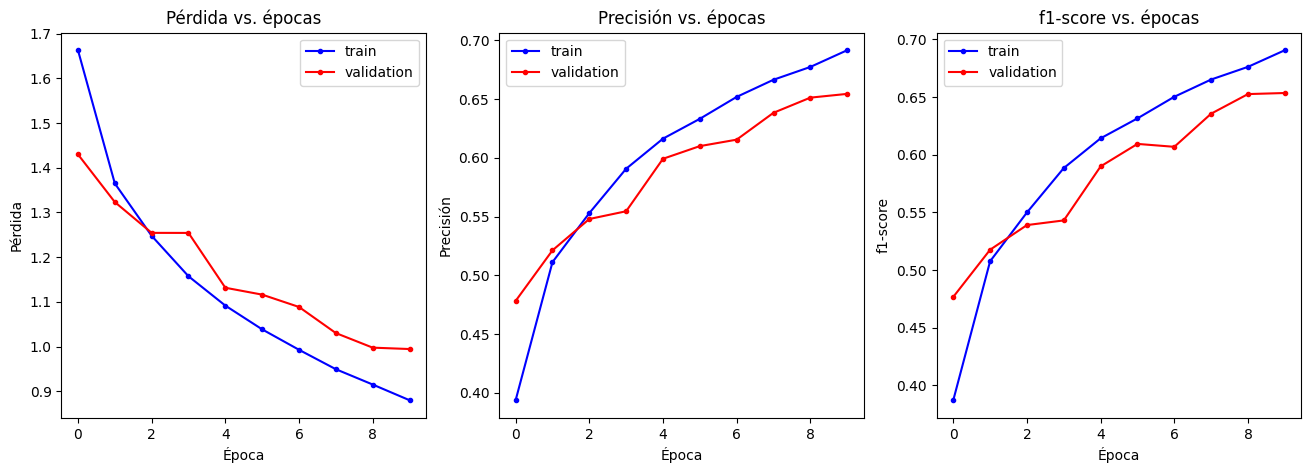

In [ ]:
# gráficas modelo con optimizador adamw

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.plot(historia.history['loss'], marker='.', color='blue', label='train')
plt.plot(historia.history['val_loss'], marker='.', color='red', label='validation')
plt.title('Pérdida vs. épocas')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend()

plt.subplot(1,3,2)
plt.plot(historia.history['accuracy'], marker='.', color='blue', label='train')
plt.plot(historia.history['val_accuracy'], marker='.', color='red', label='validation')
plt.title('Precisión vs. épocas')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend()

plt.subplot(1,3,3)
plt.plot(historia.history['f1_score'], marker='.', color='blue', label='train')
plt.plot(historia.history['val_f1_score'], marker='.', color='red', label='validation')
plt.title('f1-score vs. épocas')
plt.ylabel('f1-score')
plt.xlabel('Época')
plt.legend()

plt.show()

Comparando las métricas de entrenamiento y validación, vemos que no se está produciendo prácticamente sobreajuste, luego la regularización a través del BatchNormalization ha venido bien. Los resultados en validation y en test de **accuracy y f1-score rondan el 65%**, pudiendo ser mejores.

In [ ]:
# métricas en el conjunto de test
score = model.evaluate(x_test, y_test, verbose=0)

tabla = [['Modelo con AdamW', score[0], score[1], score[2]]]

print("MÉTRICAS EN EL CONJUNTO DE TEST\n")
print(tabulate(tabla, headers=['Modelo', 'Loss', 'Accuracy', 'f1-score']))

MÉTRICAS EN EL CONJUNTO DE TEST

Modelo                Loss    Accuracy    f1-score
----------------  --------  ----------  ----------
Modelo con AdamW  0.977062      0.6601    0.659231


In [ ]:
model.summary() # resumen de la red neuronal creada

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_17 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_16 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 average_pooling2d_16 (Aver  (None, 16, 16, 32)        0         
 agePooling2D)                                                   
                                                                 
 conv2d_27 (Conv2D)          (None, 12, 12, 16)        12816     
                                                                 
 batch_normalization_18 (Ba  (None, 12, 12, 16)      

Aplicamos ahora un **Random Forest Classifier**. Antes de nada creamos las características mediante HOG al igual que en el apartado 2.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog

In [ ]:
fd = hog(x_train[0], orientations=4, pixels_per_cell=(10,10), cells_per_block=(2, 2), visualize=False, channel_axis=-1)

x_train_HOG = np.zeros((x_train.shape[0],len(fd)), np.float32)
x_test_HOG = np.zeros((x_test.shape[0],len(fd)), np.float32)

for i in range(x_train.shape[0]):
  x_train_HOG[i] = hog(x_train[i], orientations=4, pixels_per_cell=(10, 10), cells_per_block=(2, 2), visualize=False, channel_axis=-1)
for i in range(x_test.shape[0]):
  x_test_HOG[i] = hog(x_test[i], orientations=4, pixels_per_cell=(10, 10), cells_per_block=(2, 2), visualize=False, channel_axis=-1)

In [ ]:
print(x_train_HOG.shape) # mediante HOG obtenemos 64 características para los 50000 ejemplos de entrenamiento
print(x_test_HOG.shape)  # 10000 ejemplos de test

(50000, 64)
(10000, 64)


In [ ]:
# Pasamos de tener las etiquetas en forma de matriz a vectores
y_train_vec = np.argmax(y_train, axis=1)
y_test_vec = np.argmax(y_test, axis=1)

print(y_train_vec.shape)
print(y_test_vec.shape)

(50000,)
(10000,)


Creamos el clasificador **RandomForest**. Establecemos n_estimators=100 y criterion='gini' como parámetros por defecto; además, ponemos una profundidad máxima a 20 y un número de características a 10 para reducir el tiempo de cómputo.

In [ ]:
# selección del modelo y entrenamiento con los x_train_HOG
rfModel = RandomForestClassifier( n_estimators=100, criterion='gini', max_depth=20, max_features=10, n_jobs=-1 )
rfModel.fit(x_train_HOG, y_train_vec)

# obtenemos la precisión media en test
rf_test_acc = rfModel.score(x_test_HOG, y_test_vec)
print("Mean accuracy (test) = ", rf_test_acc)

Mean accuracy (test) =  0.4698


**La precisión obtenida con el random forest es dos décimas peor que la obtenida con la red neuronal**. Seguro que ambos resultados se pueden mejorar realizando optimización de hiperparámetros.

Como **conclusión**, las redes neuronales han obtenido mejores resultados en este primer ejercicio frente a las técnicas clásicas, tanto con el conjunto de datos MNIST como con el CIFAR-10. Realizar la extracción de características y la clasificación de forma conjunta hace que el proceso sea más optimizado y dé resultados más competentes, aunque consuma más recursos computacionales.

# <font color='blue'>Ejercicio 2: PROBLEMA DE ELIMINACIÓN DE RUIDO EN IMÁGENES USANDO AUTOENCODERS (3 puntos) </font>

<font color='blue'> En este ejercicio los alumnos se enfrentarán al problema de eliminar ruido en imágenes. Para ello, se empleará el conjunto de datos $\textit{Fashion MNIST}$ (https://keras.io/api/datasets/fashion_mnist/), que contiene imágenes con 10 clases de ropa. En concreto, lo que haremos ahora es entrenar un modelo de aprendizaje automático conocido como autoencoder (que presenta una estructura _encoder-decoder_ y permite aprender representaciones (_embeddings_/_encodings_) altamente eficientes de forma no supervisada). Los autoencoders se emplean frecuentemente en tareas de reducción de dimensionalidad o detección de anomalías, y en este caso lo emplearemos para eliminar ruido en imágenes.

<font color='blue'> Referencias recomendadas sobre autoencoders:

*   <font color='blue'> Capítulo 14 de Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep learning. MIT press.
*   <font color='blue'> Hinton, G. E., & Salakhutdinov, R. R. (2006). Reducing the dimensionality of data with neural networks. Science, 313(5786), 504-507.

<font color='blue'> Se parte de la implementación proporcionada en la propia documentación de Keras (cuya revisión detallada se recomienda a los estudiantes). https://keras.io/examples/vision/autoencoder/



In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

from keras import layers
from keras.datasets import fashion_mnist
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose
from keras.optimizers import AdamW
from keras.callbacks import EarlyStopping


def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array,noise_factor):
    """Adds random noise to each image in the supplied array."""
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


4422102/4422102 [==============================] - 0s 0us/step


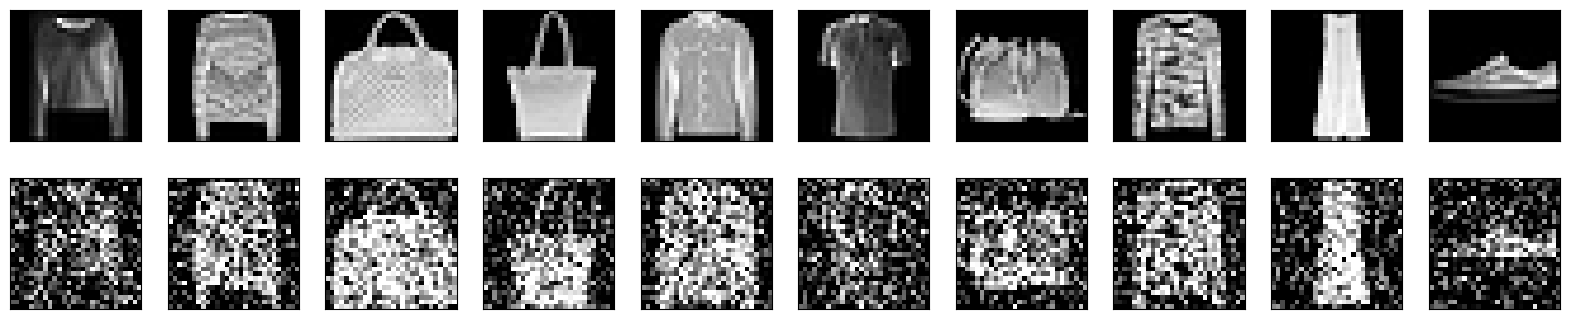

In [2]:
(train_data, _), (test_data, _) = fashion_mnist.load_data()

train_data = preprocess(train_data)
test_data = preprocess(test_data)

noise_factor = 0.4

noisy_train_data = noise(train_data,noise_factor)
noisy_test_data = noise(test_data,noise_factor)

display(train_data, noisy_train_data)

<font color='blue'> Se debe construir un autoencoder en el que la parte _encoder_ debe contener tres bloques convolucionales como se indica a continuación:

1.   64 filtros de convolución $3\times3$, función de activación _ReLU_, y volumen de salida del mismo tamaño que la entrada.
2.   32 filtros de convolución $3\times3$, función de activación _ReLU_, y volumen de salida del mismo tamaño que la entrada. Este bloque convolucional va seguido por _max pooling_ de $2\times2$.
3.   16 filtros de convolución $3\times3$, función de activación _ReLU_, y volumen de salida del mismo tamaño que la entrada. Este bloque convolucional va seguido por _max pooling_ de $2\times2$.



<font color='blue'> A partir de esta información, los estudiantes deben construir la parte _decoder_ simétrica (mismo número de filtros y dimensiones) y responder las siguientes preguntas:

-  <font color='blue'> ¿Qué tipo de convolución se debe emplear en el _decoder_? ¿Basta con emplear una convolución convencional 2D? Se debe justificar y desarrollar la respuesta.
-  <font color='blue'> ¿Cuál es la función de activación y función de pérdida que se debe emplear a la salida? ¿Por qué?

-  <font color='blue'> Ahora, a la hora de entrenar nuestro autoencoder, ¿cuáles serían las entradas ($X$) y salidas ($y$)? Y en relación con este punto, ¿por qué mencionábamos que los autoencoders son técnicas no supervisadas? ¿Cuáles son las etiquetas anotadas que empleamos?

In [3]:
# Creamos el autoencoder con Model

# Encoder
input1  = Input(shape=(28, 28, 1))  # Por ejemplo, para imágenes de 28x28 en escala de grises
hidden1 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding="same", activation="relu")(input1)
hidden2 = Conv2D(filters=32, kernel_size=(3,3), strides=1, padding="same", activation="relu")(hidden1)
hidden3 = MaxPooling2D(pool_size=(2,2))(hidden2)
hidden4 = Conv2D(filters=16, kernel_size=(3,3), strides=1, padding="same", activation="relu")(hidden3)
encoded = MaxPooling2D(pool_size=(2,2))(hidden4)

# Decoder
hidden5 = Conv2DTranspose(filters=16, kernel_size=(3,3), strides=2, padding="same", activation="relu")(encoded)
hidden6 = Conv2DTranspose(filters=32, kernel_size=(3,3), strides=2, padding="same", activation="relu")(hidden5)
hidden7 = Conv2DTranspose(filters=64, kernel_size=(3,3), strides=1, padding="same", activation="relu")(hidden6)
decoded = Conv2D(filters=1, kernel_size=(3,3), strides=1, padding="same", activation="sigmoid")(hidden7)

autoencoder = Model(input1, decoded)

In [4]:
# compilación con optimizador adamw y el learning rate por defecto
# no tiene sentido hablar de métricas en un autoencoder, comparamos sólo con la función de pérdida

autoencoder.compile(optimizer=AdamW(learning_rate=1e-3), loss="binary_crossentropy")

In [5]:
autoencoder.summary() # resumen del autoencoder

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        18464     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 16)          0         
 g2D)                                                        

Para reconstruir la imagen de la misma dimensión que la entrada, el **decoder** debe realizar <u>operaciones simétricas a las del encoder</u>.


*   **¿Qué tipo de convolución se debe emplear en el decoder? ¿Basta con emplear una convolución convencional 2D? Se debe justificar y desarrollar la respuesta**

  Para el decoder, se usan capas de convolución 2D transpuestas, que actúan como deconvoluciones con strides=2 y el mismo número de filtros que las capas de convolución anteriores. Así, vemos que obtenemos el summary del autoencoder que esperábamos, con el output shape perfectamente simétrico.

*   **¿Cuál es la función de activación y función de pérdida que se debe emplear a la salida? ¿Por qué?**

  La <u>función de activación</u> en la salida es una *sigmoide*. Es lo recomendable si los valores de los píxeles de las imágenes de entrada están normalizados en el rango [0, 1], pues así los valores de salida también estarán en este rango. Esto asegura que los valores de los píxeles reconstruidos estén en el mismo rango que los originales. Si los datos no estuvieran normalizados se usaría una función lineal (sin activación).
  
  La <u>función de pérdida</u> que usamos es binary_crossentropy, siguiendo el ejemplo de autoencoder de keras. La incluimos en los parámetros de compile, junto al optimizador AdamW.

*   **Ahora, a la hora de entrenar nuestro autoencoder, ¿cuáles serían las entradas (X) y salidas (y)? Y en relación con este punto, ¿por qué mencionábamos que los autoencoders son técnicas no supervisadas? ¿Cuáles son las etiquetas anotadas que empleamos?**

  En el entrenamiento de un autoencoder, las entradas 'X' y las salidas 'y' son las mismas, son las imágenes sin ruido. Más concretamente, la entrada serían las imágenes originales y la salida las imágenes que se han reconstruido partiendo de las originales con ruido, las cuales deben ser idealmente iguales a las originales.
  
  Los autoencoders se consideran técnicas no supervisadas porque no requieren etiquetas explícitas; el modelo aprende a codificar y decodificar los datos en función de la estructura inherente de los propios datos, sin necesidad de etiquetas adicionales.

<font color='blue'> Ahora se debe entrenar el autoencoder empleando _early stopping_, y el número de épocas, tamaño de batch y demás hiperparámetros que se consideren adecuados (justificando siempre, eso sí, las decisiones tomadas: como es habitual, bien sea basándose en la literatura científica y documentación existentes o bien en la experimentación y evidencia empírica a nuestra disposición). En un primer momento, entrenamos con las imágenes sin ruido, para verificar que somos capaces de reconstruir adecuadamente las imágenes originales de entrada. Como conjunto de validación, en este ejercicio, podemos emplear los datos de test.

In [6]:
# nos guardamos los pesos para hacer entrenamientos partiendo de los pesos originales cada vez
weights = autoencoder.get_weights()

In [ ]:
# establecemos los parámetros de fit según el ejemplo del autoencoder de keras
# además, añadimos la regularización con earlystopping
nbatch = 128
nepochs = 50
early_stopping = EarlyStopping(monitor='val_loss', patience=2)    # regularización

historia = autoencoder.fit( x=train_data, y=train_data, batch_size=nbatch, epochs=nepochs,
                            shuffle=True, callbacks=[early_stopping], validation_data=( test_data, test_data ))

Epoch 1/50
469/469 [==============================] - 10s 18ms/step - loss: 0.2983 - val_loss: 0.2712
Epoch 2/50
469/469 [==============================] - 9s 20ms/step - loss: 0.2660 - val_loss: 0.2653
Epoch 3/50
469/469 [==============================] - 9s 20ms/step - loss: 0.2616 - val_loss: 0.2618
Epoch 4/50
469/469 [==============================] - 10s 21ms/step - loss: 0.2589 - val_loss: 0.2598
Epoch 5/50
469/469 [==============================] - 10s 20ms/step - loss: 0.2573 - val_loss: 0.2585
Epoch 6/50
469/469 [==============================] - 10s 22ms/step - loss: 0.2561 - val_loss: 0.2584
Epoch 7/50
469/469 [==============================] - 10s 21ms/step - loss: 0.2552 - val_loss: 0.2573
Epoch 8/50
469/469 [==============================] - 10s 20ms/step - loss: 0.2544 - val_loss: 0.2560
Epoch 9/50
469/469 [==============================] - 11s 22ms/step - loss: 0.2537 - val_loss: 0.2554
Epoch 10/50
469/469 [==============================] - 8s 18ms/step - loss: 0.2533 -

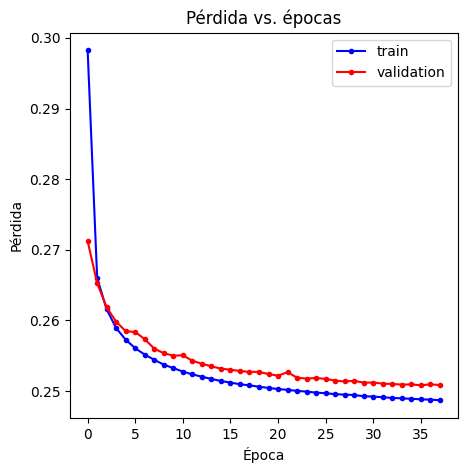

In [ ]:
# gráficas modelo con optimizador adam
# visualizamos función pérdida respecto el número de épocas

plt.figure(figsize=(5,5))

plt.subplot(1,1,1)
plt.plot(historia.history['loss'], marker='.', color='blue', label='train')
plt.plot(historia.history['val_loss'], marker='.', color='red', label='validation')
plt.title('Pérdida vs. épocas')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend()

plt.show()

Vemos cómo el entrenamiento se ha parado antes de las 50 épocas gracias al earlystopping, lo que nos ha venido muy bien para ahorrar tiempo. La función de pérdida disminuye muy lentamente. Esto mismo ocurre en el siguiente entrenamiento. A continuación se hacen las predicciones con este primer modelo entrenado. Como esperábamos, nos sale prácticamente la misma imagen, lo que significa que el autoencoder funciona perfectamente.

313/313 [==============================] - 1s 2ms/step


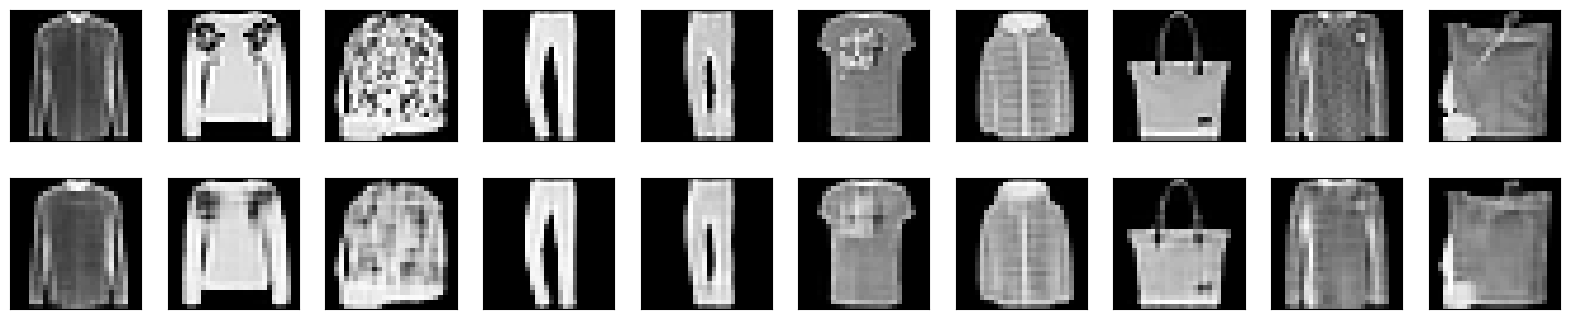

In [ ]:
#predicciones
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

<font color='blue'> Ahora vamos a entrenar con las imágenes ruidosas a la entrada y las imágenes sin ruido a la salida. Nuestro propósito es crear un modelo que permita reconstruir a la salida las imágenes sin ruido. Se deben discutir los resultados obtenidos, así como si se percibe alguna diferencia entre las curvas de entrenamiento cuando se emplean imágenes con y sin ruido.

In [ ]:
# restablecemos pesos
autoencoder.set_weights(weights)

# establecemos los parámetros del fit según los valores del ejemplo de keras
nbatch = 128
nepochs = 100
early_stopping = EarlyStopping(monitor='val_loss', patience=2)    # regularización

historia2 = autoencoder.fit( x=noisy_train_data, y=train_data, batch_size=nbatch, epochs=nepochs,
                             shuffle=True, callbacks=[early_stopping], validation_data=( noisy_test_data, test_data ))


Epoch 1/100
469/469 [==============================] - 9s 19ms/step - loss: 0.3258 - val_loss: 0.3003
Epoch 2/100
469/469 [==============================] - 8s 17ms/step - loss: 0.2950 - val_loss: 0.2949
Epoch 3/100
469/469 [==============================] - 8s 17ms/step - loss: 0.2916 - val_loss: 0.2926
Epoch 4/100
469/469 [==============================] - 8s 16ms/step - loss: 0.2897 - val_loss: 0.2909
Epoch 5/100
469/469 [==============================] - 8s 17ms/step - loss: 0.2882 - val_loss: 0.2897
Epoch 6/100
469/469 [==============================] - 8s 17ms/step - loss: 0.2872 - val_loss: 0.2899
Epoch 7/100
469/469 [==============================] - 8s 17ms/step - loss: 0.2863 - val_loss: 0.2881
Epoch 8/100
469/469 [==============================] - 10s 21ms/step - loss: 0.2856 - val_loss: 0.2873
Epoch 9/100
469/469 [==============================] - 9s 19ms/step - loss: 0.2850 - val_loss: 0.2869
Epoch 10/100
469/469 [==============================] - 9s 20ms/step - loss: 0.28

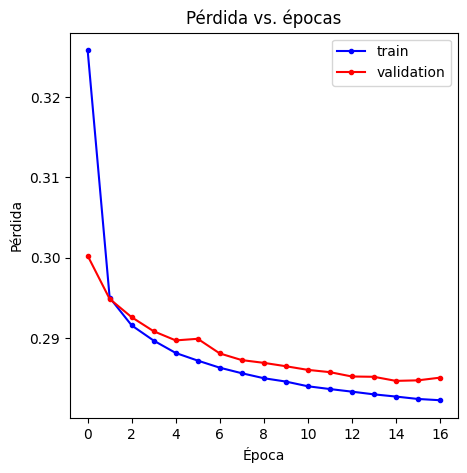

In [ ]:
# gráficas modelo con optimizador adamw
# se compara la función de pérdida respecto al número de épocas

plt.figure(figsize=(5,5))

plt.subplot(1,1,1)
plt.plot(historia2.history['loss'], marker='.', color='blue', label='train')
plt.plot(historia2.history['val_loss'], marker='.', color='red', label='validation')
plt.title('Pérdida vs. épocas')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend()

plt.show()

313/313 [==============================] - 3s 5ms/step


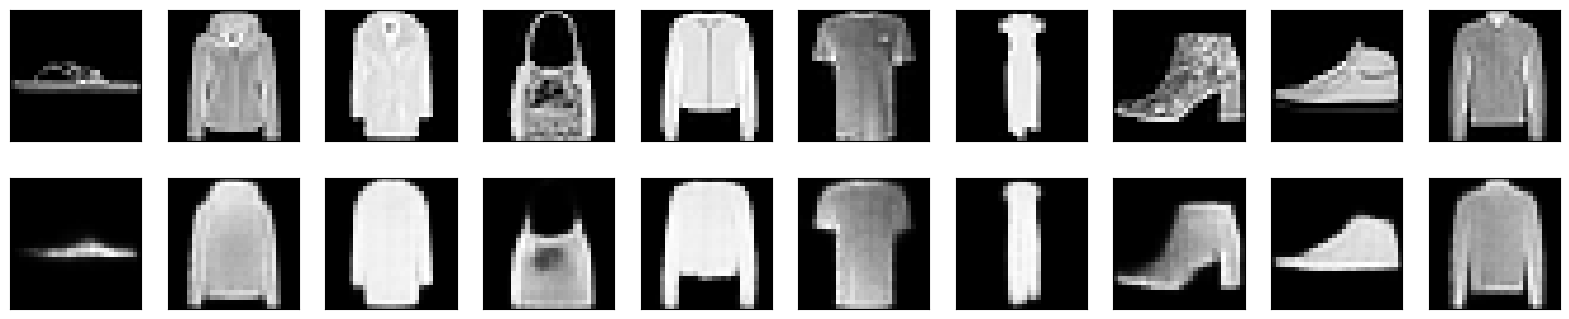

In [ ]:
# realizamos predicciones con el modelo entrenado
predictions2 = autoencoder.predict(test_data)
display(test_data, predictions2)

**Conclusiones**:

En ambos casos, tanto entrenando con las imágenes sin ruido como con ruido, el comportamiento del aprendizaje es muy similar, obteniéndose unas gráficas de función de pérdida / época muy parecidas. La diferencia entre entrenamiento y validación es mínima en ambos modelos entrenados y sólo cambia que en el primer caso se obtiene una función de pérdida ligeramente menor.

<font color='blue'> Finalmente, se deben realizar dos experimentos.  

1.   Por un lado, probar con distintos `noise_factor` progresivamente más severos de ruido, para comprobar si hay algún límite (_breakpoint_) a partir del cual la reconstrucción de las imágenes ruidosas se resiente. En otras palabras, queremos estudiar hasta qué grado de ruidosidad podemos reconstruir nuestras imágenes contaminadas con ruido.

Para estudiar si hay un límite de ruido para el cual el autoencoder no es capaz de reconstruir las imágenes, realizamos un **bucle for en el que tratamos 5 factores de ruido diferentes** (0.4, 0.5, 0.6, 0.7, 0.8).

En cada iteración, mostramos las imágenes originales y las imágenes con el ruido correspondiente (mediante la función display), entrenamos el autoencoder tomando como entrada las imágenes con ruido y como salida las imágenes originales, y mostramos 10 imágenes reconstruidas junto a las originales.

Finalmente, en una tabla mostramos los valores de la función de pérdida encontrados para cada factor de ruido en el conjunto de test.

Imágenes originales / Imágenes con ruido 0.4


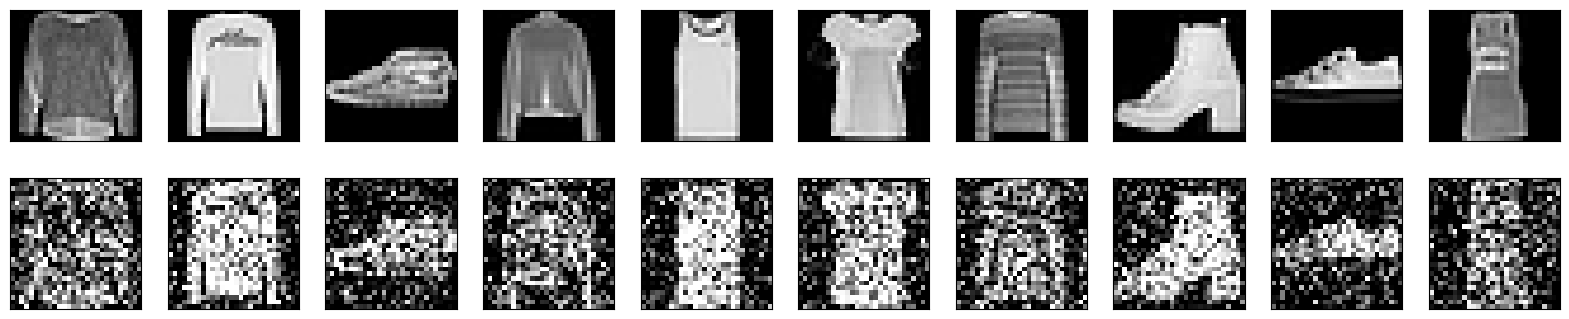

313/313 [==============================] - 2s 5ms/step
Imágenes reconstruidas / Salida esperada


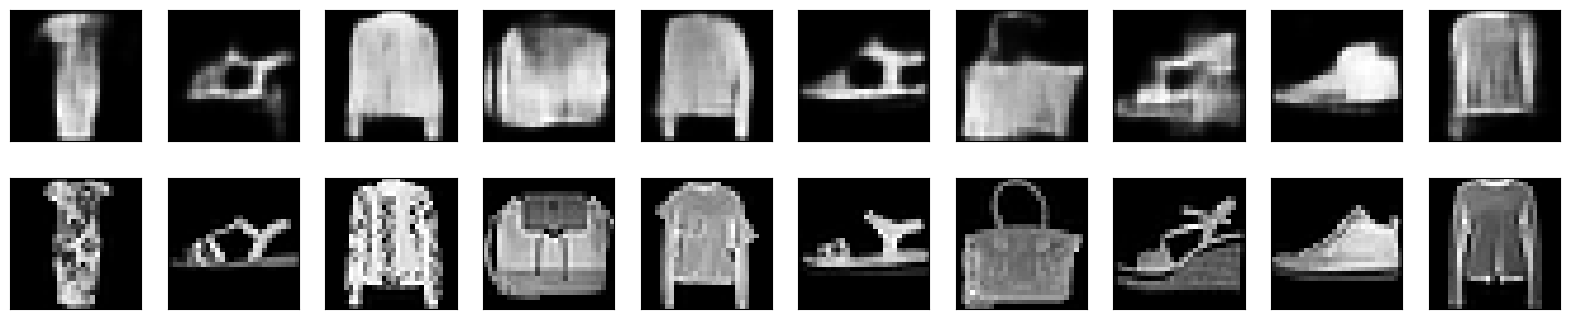

Imágenes originales / Imágenes con ruido 0.4


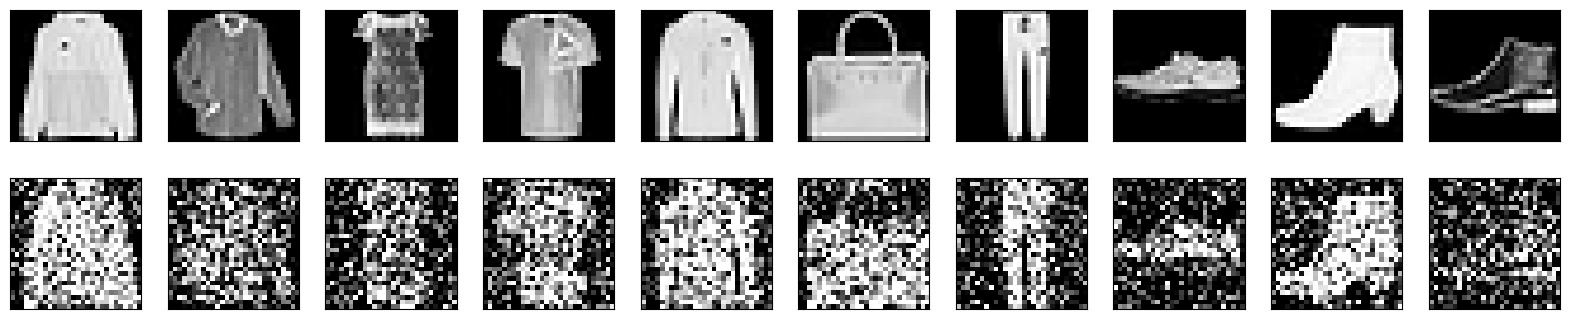

313/313 [==============================] - 1s 3ms/step
Imágenes reconstruidas / Salida esperada


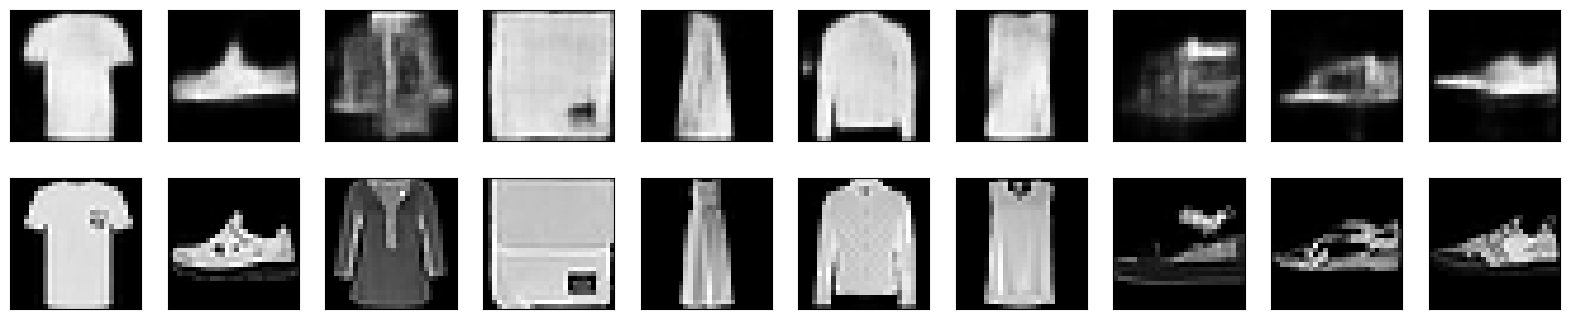

Imágenes originales / Imágenes con ruido 0.4


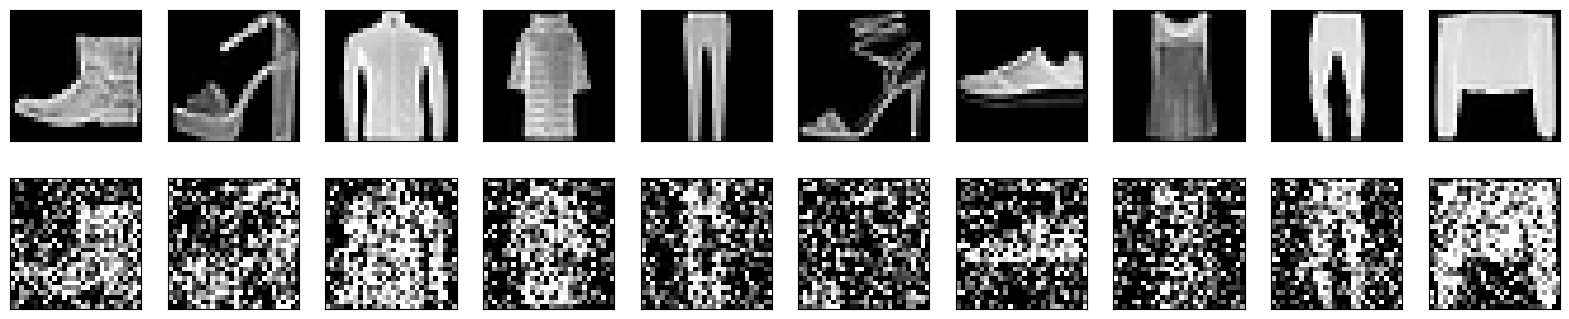

313/313 [==============================] - 1s 3ms/step
Imágenes reconstruidas / Salida esperada


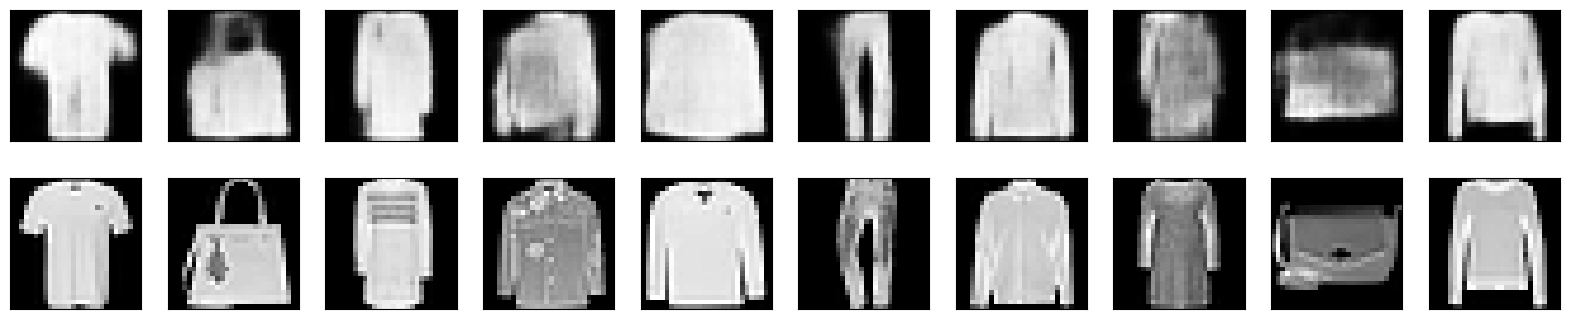

Imágenes originales / Imágenes con ruido 0.4


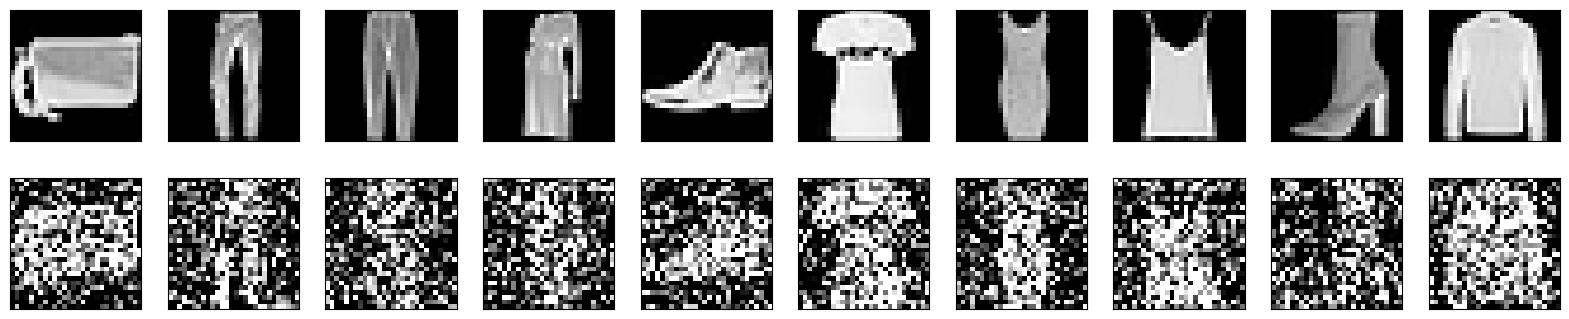

313/313 [==============================] - 1s 2ms/step
Imágenes reconstruidas / Salida esperada


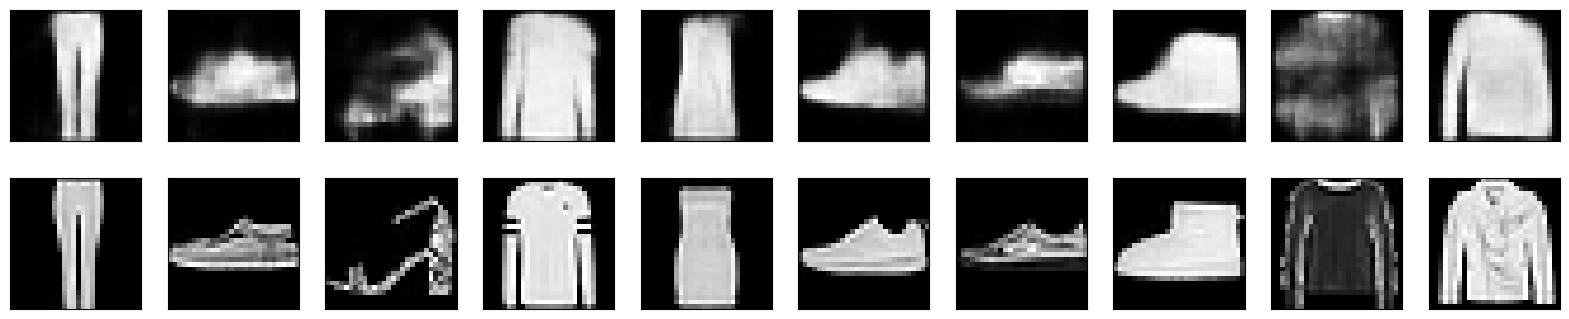

Imágenes originales / Imágenes con ruido 0.4


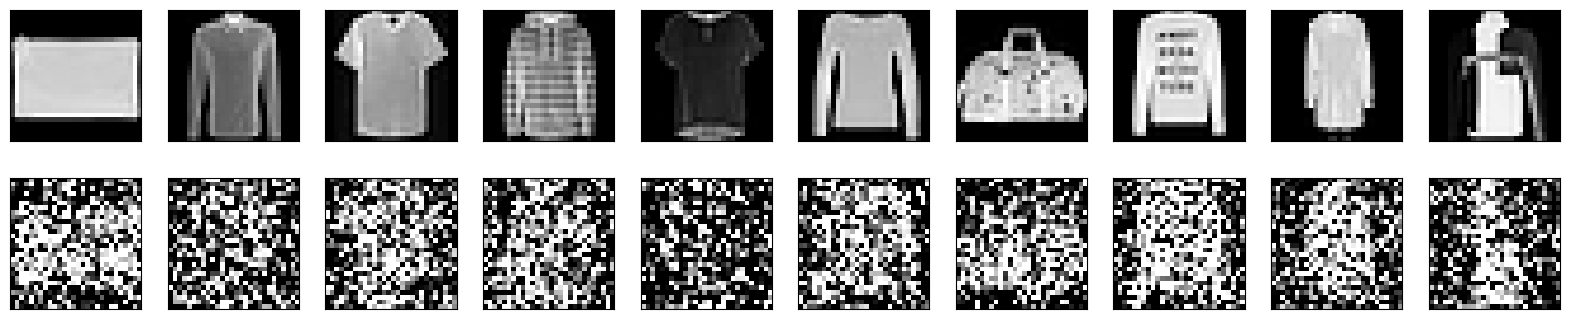

313/313 [==============================] - 1s 2ms/step
Imágenes reconstruidas / Salida esperada


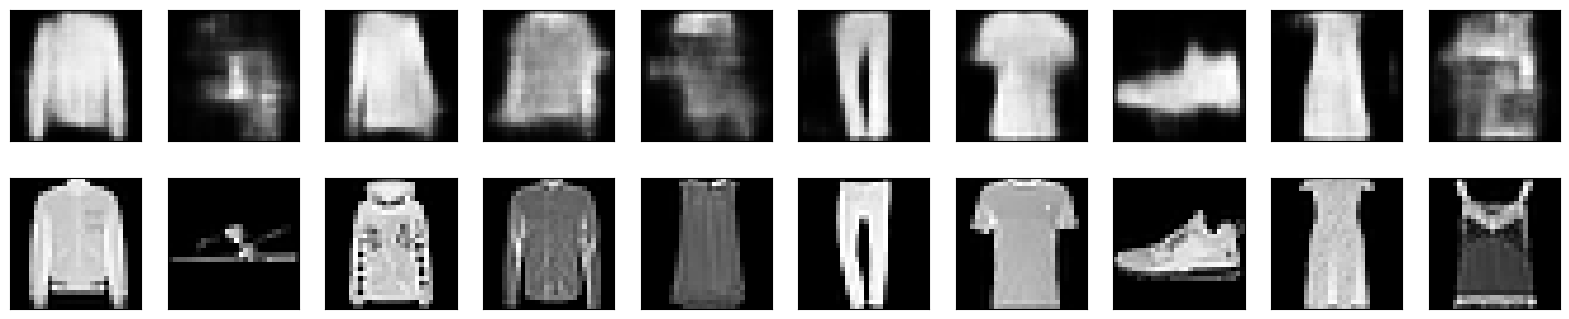

MÉTRICAS EN EL CONJUNTO DE TEST

  noisy_factor      Loss
--------------  --------
           0.4  0.284959
           0.5  0.295639
           0.6  0.305713
           0.7  0.316055
           0.8  0.327927


In [10]:
noise_factors = [0.4, 0.5, 0.6, 0.7, 0.8]
loss_score = []
i=0

for factor in noise_factors:
  i = i+1

  # creamos conjunto de datos con ruido
  noisy_train_data = noise(train_data, factor)
  noisy_test_data  = noise(test_data, factor)

  # mostramos los datos con ruido con los que estamos entrenando
  # en la ejecución actual se me olvidó incrementar la variable i y siempre se escribe el factor de ruido 0.4
  print("Imágenes originales / Imágenes con ruido {}".format(noise_factors[i]))
  display(train_data, noisy_train_data)

  # restablecemos pesos
  autoencoder.set_weights(weights)

  # establecemos los parámetros del fit según el primer entrenamiento
  nbatch = 128
  nepochs = 50
  early_stopping = EarlyStopping(monitor='val_loss', patience=2)    # regularización

  # entrenamos el autoencoder
  historia = autoencoder.fit( x=noisy_train_data, y=train_data, batch_size=nbatch, epochs=nepochs,
                              shuffle=True, callbacks=[early_stopping], validation_data=( noisy_test_data, test_data ), verbose=0)

  # evaluamos, obtenemos valor de la función de pérdida
  score = autoencoder.evaluate(noisy_test_data, test_data)
  loss_score.append(score)

  # predecimos las imágenes y mostramos 10 random usando la función display
  images_pred = autoencoder.predict(noisy_test_data)
  print("Imágenes reconstruidas / Salida esperada")
  display(images_pred, test_data)


# loss function en el conjunto de test
tabla = [[noise_factors[0], loss_score[0]],
         [noise_factors[1], loss_score[1]],
         [noise_factors[2], loss_score[2]],
         [noise_factors[3], loss_score[3]],
         [noise_factors[4], loss_score[4]]]


print("MÉTRICAS EN EL CONJUNTO DE TEST\n")
print(tabulate(tabla, headers=['noisy_factor', 'Loss']))


**Conclusiones experimento 1**:

Viendo las imágenes reconstruidas por cada autoencoder, podemos decir que para un factor de ruido de 0.7 (y 0.8) salen imágenes bastante difuminadas que poco se asemejan a las originales. Con 0.6 sí se consiguen unas imágenes más decentes; luego, siendo optimistas, podemos determinar el <u>umbral a 0.6</u>. Con factores de ruido de 0.4 y 0.5 sí se obtienen buenas reconstrucciones, aunque es cierto que siempre se pierden detalles de las ropas. El autoencoder da mejores resultados cuando hay más contrastes en la imagen de blancos y negros; mientras que si son tonos grisáceos, el borde empieza a difuminarse más. En concreto, hay unas zapatillas oscuras que se reconstruyen muy mal con prácticamente cualquier nivel de ruido.

Según la última tabla, vemos cómo con cada décima que aumentamos el factor de ruido se aumenta en una centésima la función de pérdida. Es una relación directamente proporcional.


<font color='blue'>2. Por otro lado, debemos investigar si el autoencoder entrenado generaliza y permite reconstruir imágenes en presencia de ruido diferente. Sin realizar ningún otro entrenamiento, y empleando el autoencoder ya entrenado, ¿podemos reconstruir las imágenes contaminadas con este otro tipo de ruido? Para simular dicho ruido se debe emplear la función que se proporciona más abajo (`noise2()`), aunque se da libertad al alumnado para experimentar también con otros tipos de ruido. ¿Qué conclusiones se pueden extraer de este experimento?</font>

In [11]:
def noise2(image, noise_factor):
    noisy_array = image.copy()
    probs = np.random.random(noisy_array.shape[:2])
    noisy_array[probs < noise_factor/2] = 0.0
    noisy_array[probs > 1 - (noise_factor/2)] = 1.0
    return np.clip(noisy_array, 0.0, 1.0)

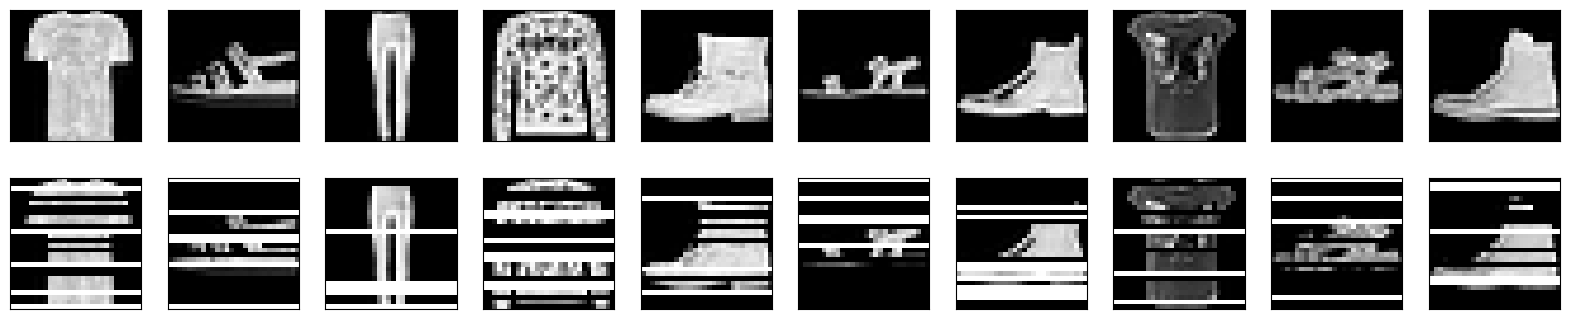

In [12]:
noise_factor = 0.4

noisy_test_data2 = noise2(test_data,noise_factor)

display(test_data, noisy_test_data2)

In [14]:
# retomamos el autoencoder anterior
autoencoder.set_weights(weights)
nbatch = 128
nepochs = 50
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# entrenamiento con las imágenes con ruido de tipo 1
historia = autoencoder.fit( x=noisy_train_data, y=train_data, batch_size=nbatch, epochs=nepochs,
                            shuffle=True, callbacks=[early_stopping], validation_data=( noisy_test_data, test_data ))


Epoch 1/50
469/469 [==============================] - 8s 17ms/step - loss: 0.3816 - val_loss: 0.3504
Epoch 2/50
469/469 [==============================] - 8s 18ms/step - loss: 0.3444 - val_loss: 0.3448
Epoch 3/50
469/469 [==============================] - 9s 19ms/step - loss: 0.3384 - val_loss: 0.3383
Epoch 4/50
469/469 [==============================] - 11s 22ms/step - loss: 0.3354 - val_loss: 0.3360
Epoch 5/50
469/469 [==============================] - 9s 19ms/step - loss: 0.3334 - val_loss: 0.3346
Epoch 6/50
469/469 [==============================] - 8s 18ms/step - loss: 0.3320 - val_loss: 0.3343
Epoch 7/50
469/469 [==============================] - 8s 16ms/step - loss: 0.3310 - val_loss: 0.3324
Epoch 8/50
469/469 [==============================] - 8s 17ms/step - loss: 0.3300 - val_loss: 0.3330
Epoch 9/50
469/469 [==============================] - 8s 17ms/step - loss: 0.3292 - val_loss: 0.3309
Epoch 10/50
469/469 [==============================] - 8s 16ms/step - loss: 0.3285 - val_l

313/313 [==============================] - 1s 4ms/step - loss: 0.5294
Loss:  0.5294050574302673
313/313 [==============================] - 1s 2ms/step


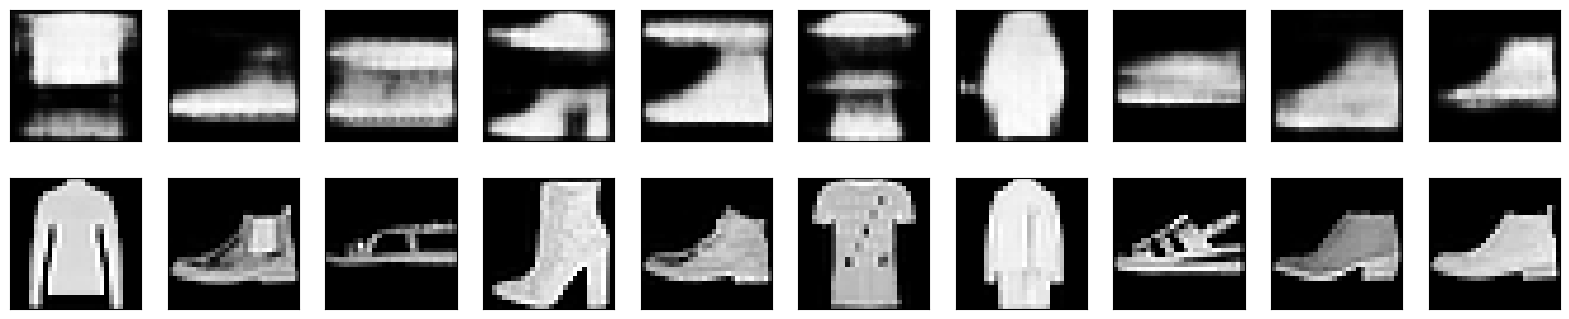

In [16]:
# evaluamos, obtenemos valor de la función de pérdida para las imágenes con ruido de tipo 2
score = autoencoder.evaluate(noisy_test_data2, test_data)
print("Loss: ", score)

# predecimos las imágenes y mostramos 10 random usando la función display
images_recons = autoencoder.predict(noisy_test_data2)
display(images_recons, test_data)

**Conclusiones experimento 2**:

Por un lado, viendo el valor de la función de pérdida ya podemos intuir que el autoencoder va a reconstruir peor estas imágenes, pues es un valor mayor respecto a los obtenidos con el otro tipo de ruido. Comparando las imágenes reconstruidas con las originales, vemos cómo <u>el autoencoder produce imágenes muy diferentes y con bastantes inconsistencias</u>, introduciéndose manchas negras o blancas donde no debería haberlas.

Podemos concluir que <u>si los autoencoders se entrenan para eliminar un tipo de ruido de las imágenes estos no saben tratar con otros ruidos diferentes</u>. Por tanto, es muy importante entrenarlos con un conjunto de imágenes apropiado que nos interese y sabiendo cómo se han entrenado, saber discernir sobre qué imágenes se pueden aplicar y en cuáles no.